# Comparative Analysis of All Models for g-k Pair

This notebook analyzes and compares results from all trained models for g-k phoneme classification:
- **Hybrid CNN+MLP V3** (from `03.1_g-k_improved_hybrid_cnn_mlp_with_context.ipynb`)
- **Hybrid CNN+MLP V4** (from `03.2_g-k_improved_hybrid_cnn_mlp_v4_with_context.ipynb`)
- **Hybrid CNN+MLP V4 Optimized** (from `03.2.2_g-k_improved_hybrid_cnn_mlp_v4_optimized.ipynb`)
- **Classical ML Models** (from `03.3_ML_g-k_classification.ipynb`)

For each model, we will:
1. Load predictions and metrics
2. Create confusion matrices
3. Compare performance metrics across models
4. Analyze probability distributions
5. Identify best performing model


In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Project root
PROJECT_ROOT = Path('/Volumes/SSanDisk/SpeechRec-German')

# Define paths for all models
MODELS_CONFIG = {
    'V3': {
        'name': 'Hybrid CNN+MLP V3',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context' / 'features' / 'features.parquet'
    },
    'V4': {
        'name': 'Hybrid CNN+MLP V4',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'V4_Optimized': {
        'name': 'Hybrid CNN+MLP V4 Optimized',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'ML_Models': {
        'name': 'Classical ML Models',
        'type': 'machine_learning',
        'results_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'ml_results' / 'all_results.json',
        'results_csv_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'ml_results' / 'all_results.csv',
        'features_path': PROJECT_ROOT / 'artifacts' / 'g-k_dl_models_with_context_v2' / 'features' / 'features.parquet'
    }
}

# Class labels for g-k pair
CLASS_0 = 'g'
CLASS_1 = 'k'

print("Configuration loaded successfully!")
print(f"\nAnalyzing {len(MODELS_CONFIG)} model groups:")
for model_key, config in MODELS_CONFIG.items():
    print(f"  - {config['name']} ({config['type']})")


Configuration loaded successfully!

Analyzing 4 model groups:
  - Hybrid CNN+MLP V3 (deep_learning)
  - Hybrid CNN+MLP V4 (deep_learning)
  - Hybrid CNN+MLP V4 Optimized (deep_learning)
  - Classical ML Models (machine_learning)


## Part 1: Load Data for All Models


In [2]:
# Load data for all deep learning models
all_predictions = {}
all_metrics = {}

print("="*80)
print("LOADING DATA FOR ALL MODELS")
print("="*80)

# Load Deep Learning models
for model_key, config in MODELS_CONFIG.items():
    if config['type'] == 'deep_learning':
        print(f"\nLoading {config['name']}...")
        try:
            # Load predictions
            if config['predictions_path'].exists():
                predictions_df = pd.read_csv(config['predictions_path'])
                all_predictions[model_key] = predictions_df
                print(f"  ✓ Loaded {len(predictions_df)} predictions")
                print(f"    Correct: {predictions_df['is_correct'].sum()}, Incorrect: {(~predictions_df['is_correct'].astype(bool)).sum()}")
            else:
                print(f"  ✗ Predictions file not found: {config['predictions_path']}")
                continue
            
            # Load metrics
            if config['metrics_path'].exists():
                with open(config['metrics_path'], 'r') as f:
                    metrics = json.load(f)
                all_metrics[model_key] = metrics
                print(f"  ✓ Loaded metrics:")
                print(f"    Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
            else:
                print(f"  ✗ Metrics file not found: {config['metrics_path']}")
        except Exception as e:
            print(f"  ✗ Error loading {config['name']}: {e}")

# Load ML models results
print(f"\nLoading {MODELS_CONFIG['ML_Models']['name']}...")
try:
    if MODELS_CONFIG['ML_Models']['results_path'].exists():
        with open(MODELS_CONFIG['ML_Models']['results_path'], 'r') as f:
            ml_results = json.load(f)
        all_metrics['ML_Models'] = ml_results
        print(f"  ✓ Loaded results for {len(ml_results)} ML models")
        
        # Load CSV for detailed analysis
        if MODELS_CONFIG['ML_Models']['results_csv_path'].exists():
            ml_results_df = pd.read_csv(MODELS_CONFIG['ML_Models']['results_csv_path'])
            print(f"  ✓ Loaded detailed results CSV")
    else:
        print(f"  ✗ ML results file not found: {MODELS_CONFIG['ML_Models']['results_path']}")
except Exception as e:
    print(f"  ✗ Error loading ML models: {e}")

print(f"\n{'='*80}")
print(f"Successfully loaded {len(all_predictions)} deep learning models and {1 if 'ML_Models' in all_metrics else 0} ML model group")
print(f"{'='*80}")


LOADING DATA FOR ALL MODELS

Loading Hybrid CNN+MLP V3...
  ✓ Loaded 5698 predictions
    Correct: 5495, Incorrect: 203
  ✓ Loaded metrics:
    Accuracy: 0.9644, F1: 0.9644, ROC-AUC: 0.9846

Loading Hybrid CNN+MLP V4...
  ✓ Loaded 5698 predictions
    Correct: 5474, Incorrect: 224
  ✓ Loaded metrics:
    Accuracy: 0.9607, F1: 0.9606, ROC-AUC: 0.9902

Loading Hybrid CNN+MLP V4 Optimized...
  ✓ Loaded 5698 predictions
    Correct: 5505, Incorrect: 193
  ✓ Loaded metrics:
    Accuracy: 0.9661, F1: 0.9661, ROC-AUC: 0.9859

Loading Classical ML Models...
  ✓ Loaded results for 12 ML models
  ✓ Loaded detailed results CSV

Successfully loaded 3 deep learning models and 1 ML model group


## Part 2: Comparative Performance Analysis


In [3]:
# Create comparison dataframe for all models
comparison_data = []

# Add Deep Learning models
for model_key, metrics in all_metrics.items():
    if model_key != 'ML_Models':
        comparison_data.append({
            'Model': MODELS_CONFIG[model_key]['name'],
            'Type': 'Deep Learning',
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC-AUC': metrics['roc_auc'],
            'Precision_g': metrics.get('precision_g', metrics.get('precision_per_class', [0, 0])[0]),
            'Precision_k': metrics.get('precision_k', metrics.get('precision_per_class', [0, 0])[1]),
            'Recall_g': metrics.get('recall_g', metrics.get('recall_per_class', [0, 0])[0]),
            'Recall_k': metrics.get('recall_k', metrics.get('recall_per_class', [0, 0])[1]),
            'F1_g': metrics.get('f1_g', metrics.get('f1_per_class', [0, 0])[0]),
            'F1_k': metrics.get('f1_k', metrics.get('f1_per_class', [0, 0])[1])
        })

# Add best ML model
if 'ML_Models' in all_metrics and 'ml_results_df' in locals():
    best_ml = ml_results_df.iloc[0]  # Already sorted by test_f1_weighted
    comparison_data.append({
        'Model': f"ML: {best_ml['model_name']}",
        'Type': 'Machine Learning',
        'Accuracy': best_ml['test_accuracy'],
        'F1-Score': best_ml['test_f1_weighted'],
        'Precision': best_ml['test_precision'],
        'Recall': best_ml['test_recall'],
        'ROC-AUC': best_ml.get('test_roc_auc', np.nan),
        'Precision_g': np.nan,
        'Precision_k': np.nan,
        'Recall_g': np.nan,
        'Recall_k': np.nan,
        'F1_g': np.nan,
        'F1_k': np.nan
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("="*80)
print("PERFORMANCE COMPARISON ACROSS ALL MODELS")
print("="*80)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model['Model']}")
print(f"{'='*80}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print(f"ROC-AUC: {best_model['ROC-AUC']:.4f}")


PERFORMANCE COMPARISON ACROSS ALL MODELS

                      Model             Type  Accuracy  F1-Score  Precision   Recall  ROC-AUC  Precision_g  Precision_k  Recall_g  Recall_k  F1_g     F1_k
Hybrid CNN+MLP V4 Optimized    Deep Learning  0.966128  0.966141   0.966165 0.966128 0.985890          0.0     0.956958       0.0  0.962185   0.0 0.959564
          Hybrid CNN+MLP V3    Deep Learning  0.964373  0.964393   0.964425 0.964373 0.984579          0.0     0.952588       0.0  0.958844   0.0 0.955706
          Hybrid CNN+MLP V4    Deep Learning  0.960688  0.960637   0.960693 0.960688 0.990174          0.0     0.961078       0.0  0.944118   0.0 0.952522
               ML: Stacking Machine Learning  0.960161  0.960177   0.960202 0.960161 0.992260          NaN          NaN       NaN       NaN   NaN      NaN

BEST MODEL: Hybrid CNN+MLP V4 Optimized
Accuracy: 0.9661
F1-Score: 0.9661
ROC-AUC: 0.9859


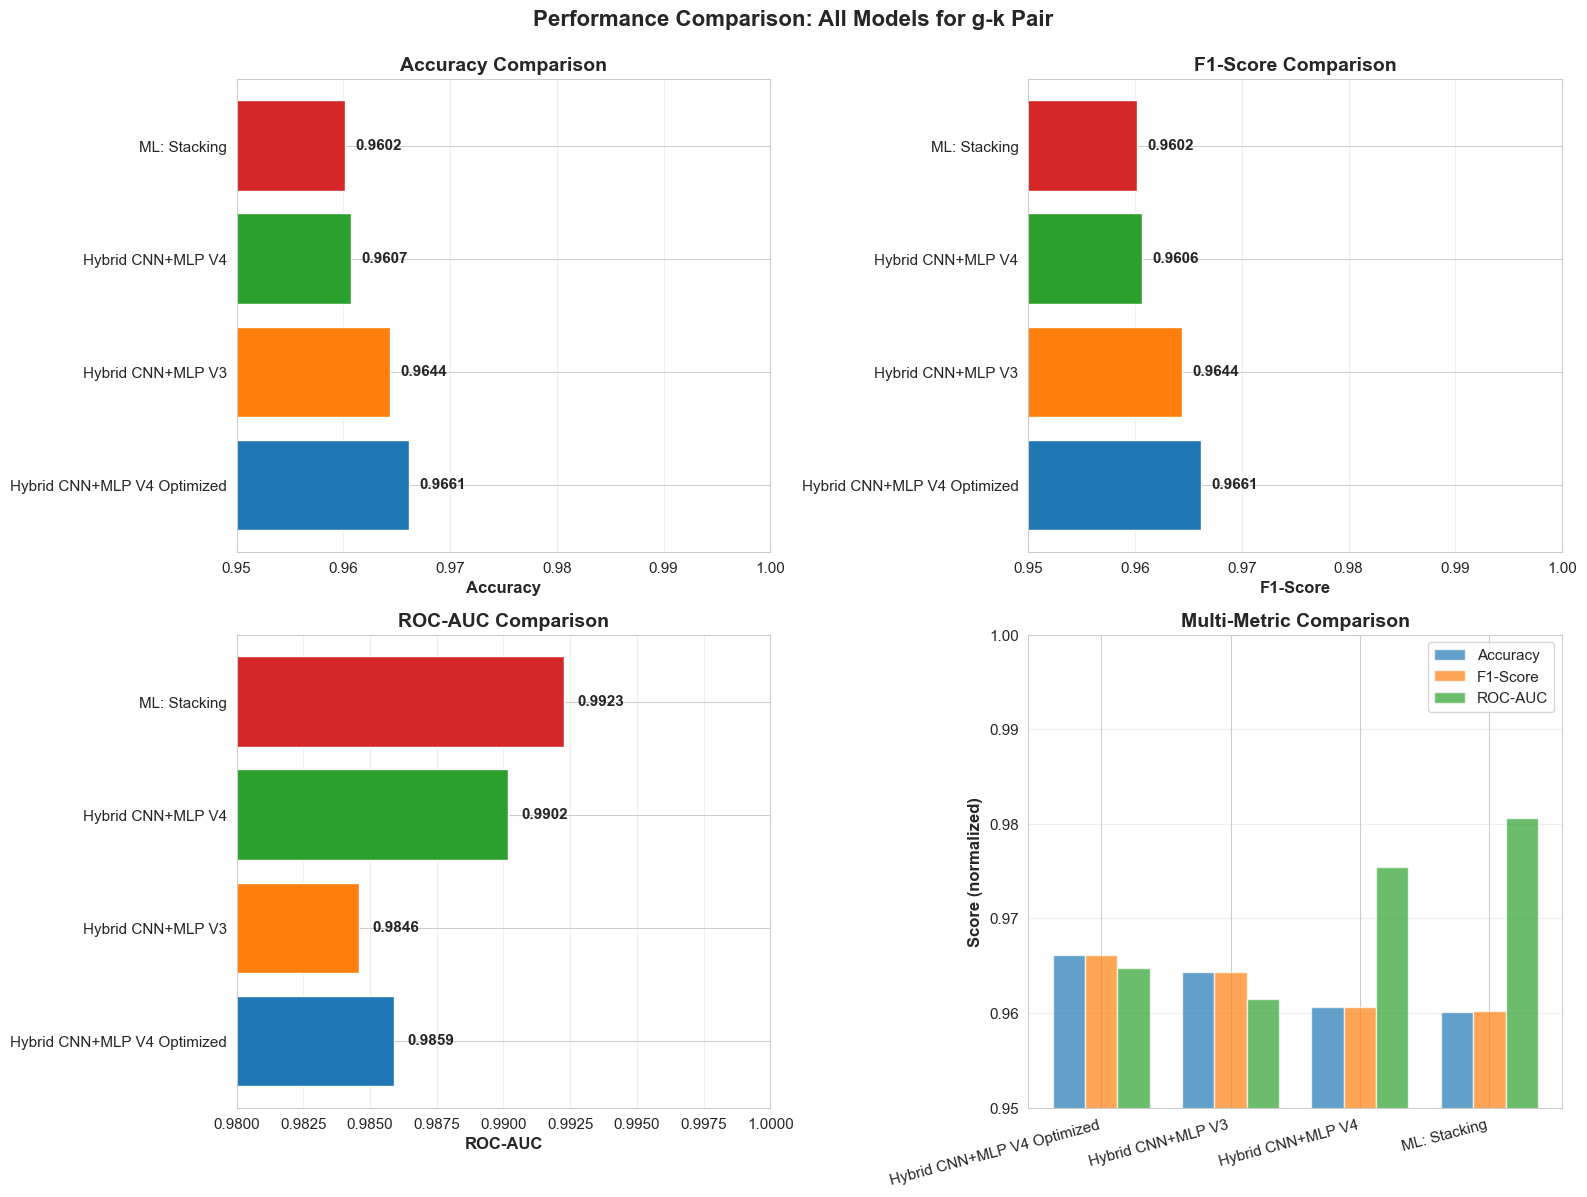

In [4]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors[:len(comparison_df)])
ax1.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
ax1.set_xlim([0.95, 1.0])
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, acc) in enumerate(zip(bars, comparison_df['Accuracy'])):
    ax1.text(acc + 0.001, i, f'{acc:.4f}', va='center', fontweight='bold')

# 2. F1-Score comparison
ax2 = axes[0, 1]
bars = ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors[:len(comparison_df)])
ax2.set_xlabel('F1-Score', fontweight='bold', fontsize=12)
ax2.set_title('F1-Score Comparison', fontweight='bold', fontsize=14)
ax2.set_xlim([0.95, 1.0])
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, f1) in enumerate(zip(bars, comparison_df['F1-Score'])):
    ax2.text(f1 + 0.001, i, f'{f1:.4f}', va='center', fontweight='bold')

# 3. ROC-AUC comparison
ax3 = axes[1, 0]
bars = ax3.barh(comparison_df['Model'], comparison_df['ROC-AUC'], color=colors[:len(comparison_df)])
ax3.set_xlabel('ROC-AUC', fontweight='bold', fontsize=12)
ax3.set_title('ROC-AUC Comparison', fontweight='bold', fontsize=14)
ax3.set_xlim([0.98, 1.0])
ax3.grid(True, alpha=0.3, axis='x')
for i, (bar, roc) in enumerate(zip(bars, comparison_df['ROC-AUC'])):
    if not pd.isna(roc):
        ax3.text(roc + 0.0005, i, f'{roc:.4f}', va='center', fontweight='bold')

# 4. Multi-metric radar chart (simplified as grouped bar)
ax4 = axes[1, 1]
x = np.arange(len(comparison_df))
width = 0.25
metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    # Normalize ROC-AUC for comparison (scale to 0.95-1.0 range)
    if metric == 'ROC-AUC':
        values = 0.95 + (values - 0.98) * (0.05 / 0.02) if not pd.isna(values).all() else values
    ax4.bar(x + idx*width, values, width, label=metric, alpha=0.7)
ax4.set_ylabel('Score (normalized)', fontweight='bold', fontsize=12)
ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
ax4.set_xticks(x + width)
ax4.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.set_ylim([0.95, 1.0])
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Performance Comparison: All Models for g-k Pair', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Part 3: Confusion Matrices for All Deep Learning Models


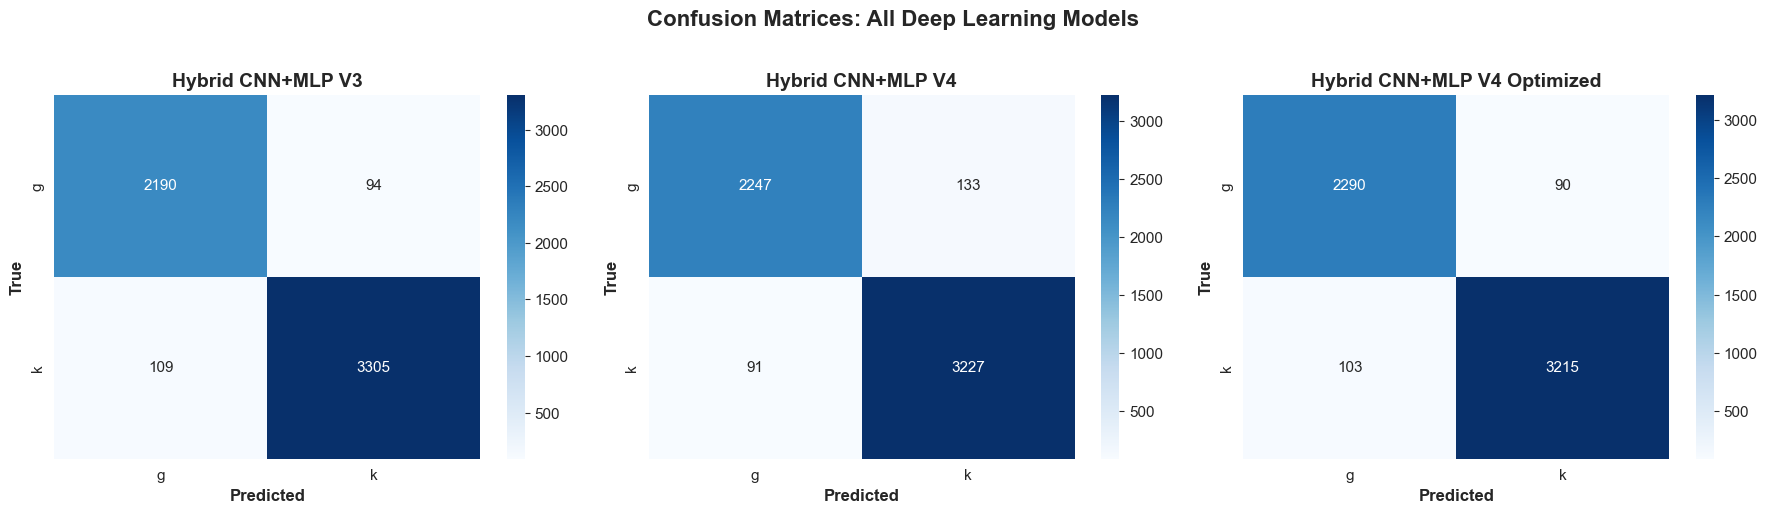

CLASSIFICATION REPORTS

Hybrid CNN+MLP V3:
------------------------------------------------------------
              precision    recall  f1-score   support

           g     0.9526    0.9588    0.9557      2284
           k     0.9723    0.9681    0.9702      3414

    accuracy                         0.9644      5698
   macro avg     0.9625    0.9635    0.9630      5698
weighted avg     0.9644    0.9644    0.9644      5698


Hybrid CNN+MLP V4:
------------------------------------------------------------
              precision    recall  f1-score   support

           g     0.9611    0.9441    0.9525      2380
           k     0.9604    0.9726    0.9665      3318

    accuracy                         0.9607      5698
   macro avg     0.9607    0.9583    0.9595      5698
weighted avg     0.9607    0.9607    0.9606      5698


Hybrid CNN+MLP V4 Optimized:
------------------------------------------------------------
              precision    recall  f1-score   support

           g   

In [5]:
# Create confusion matrices for all deep learning models
n_models = len(all_predictions)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    ax = axes[idx]
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[CLASS_0, CLASS_1],
                yticklabels=[CLASS_0, CLASS_1])
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('True', fontsize=12, fontweight='bold')
    ax.set_title(f'{MODELS_CONFIG[model_key]["name"]}', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices: All Deep Learning Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("="*80)
print("CLASSIFICATION REPORTS")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print("-" * 60)
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    print(classification_report(y_true, y_pred, 
                                target_names=[CLASS_0, CLASS_1],
                                digits=4))


## Part 4: Probability Distribution Analysis


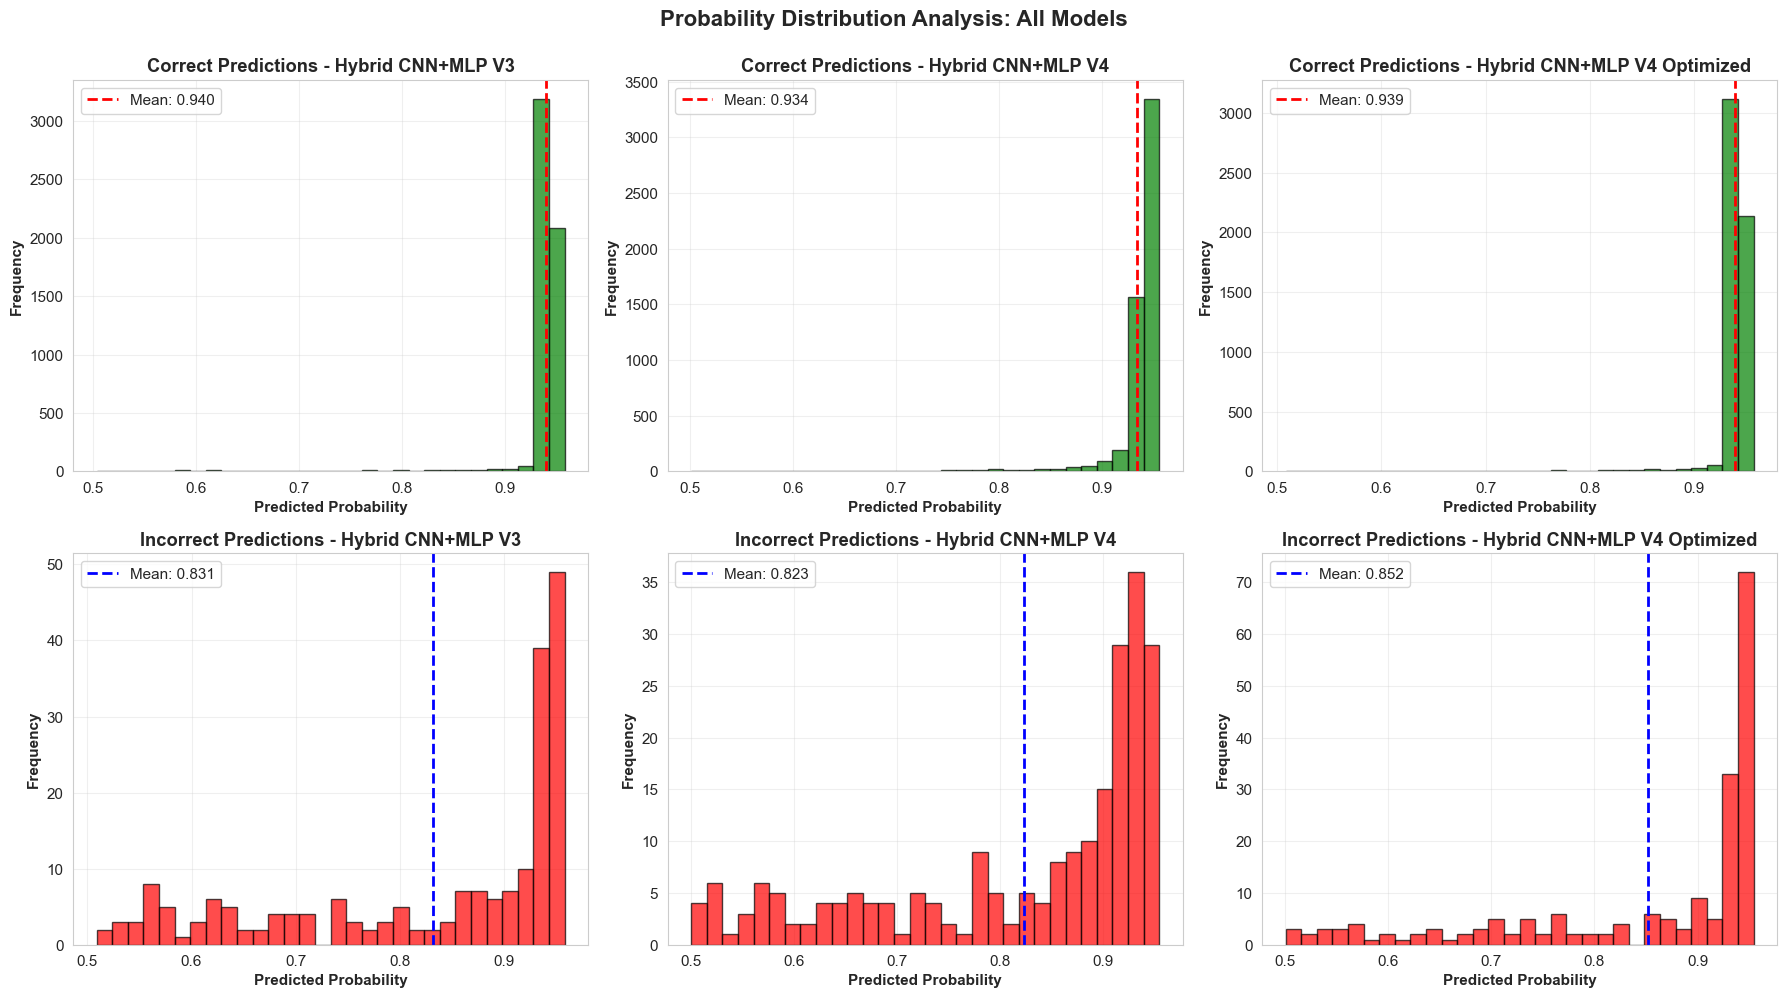

PROBABILITY STATISTICS COMPARISON

Hybrid CNN+MLP V3:
  Correct predictions:
    Mean: 0.9400, Median: 0.9387, Std: 0.0371
  Incorrect predictions:
    Mean: 0.8313, Median: 0.9089, Std: 0.1420
  Separation: 0.1087

Hybrid CNN+MLP V4:
  Correct predictions:
    Mean: 0.9336, Median: 0.9409, Std: 0.0441
  Incorrect predictions:
    Mean: 0.8226, Median: 0.8885, Std: 0.1356
  Separation: 0.1111

Hybrid CNN+MLP V4 Optimized:
  Correct predictions:
    Mean: 0.9389, Median: 0.9395, Std: 0.0370
  Incorrect predictions:
    Mean: 0.8522, Median: 0.9310, Std: 0.1318
  Separation: 0.0867


In [6]:
# Compare probability distributions across models
n_models = len(all_predictions)
fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

if n_models == 1:
    axes = axes.reshape(2, 1)

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    # Top row: Correct predictions
    ax1 = axes[0, idx]
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    ax1.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax1.axvline(correct_probs.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {correct_probs.mean():.3f}')
    ax1.set_xlabel('Predicted Probability', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title(f'Correct Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: Incorrect predictions
    ax2 = axes[1, idx]
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    ax2.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
    ax2.axvline(incorrect_probs.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {incorrect_probs.mean():.3f}')
    ax2.set_xlabel('Predicted Probability', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title(f'Incorrect Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.suptitle('Probability Distribution Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statistics comparison
print("="*80)
print("PROBABILITY STATISTICS COMPARISON")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print(f"  Correct predictions:")
    print(f"    Mean: {correct_probs.mean():.4f}, Median: {np.median(correct_probs):.4f}, Std: {correct_probs.std():.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Mean: {incorrect_probs.mean():.4f}, Median: {np.median(incorrect_probs):.4f}, Std: {incorrect_probs.std():.4f}")
    print(f"  Separation: {correct_probs.mean() - incorrect_probs.mean():.4f}")


## Part 5: Error Analysis


ERROR ANALYSIS COMPARISON

                      Model  Total Errors  Error Rate %  High Conf Errors  High Conf Errors %  Low Conf Errors  Low Conf Errors %  Errors g  Error Rate g %  Errors k  Error Rate k %
          Hybrid CNN+MLP V3           203      3.562654               136           66.995074               24          11.822660         0               0        94        4.115587
          Hybrid CNN+MLP V4           224      3.931204               148           66.071429               27          12.053571         0               0       133        5.588235
Hybrid CNN+MLP V4 Optimized           193      3.387153               140           72.538860               16           8.290155         0               0        90        3.781513


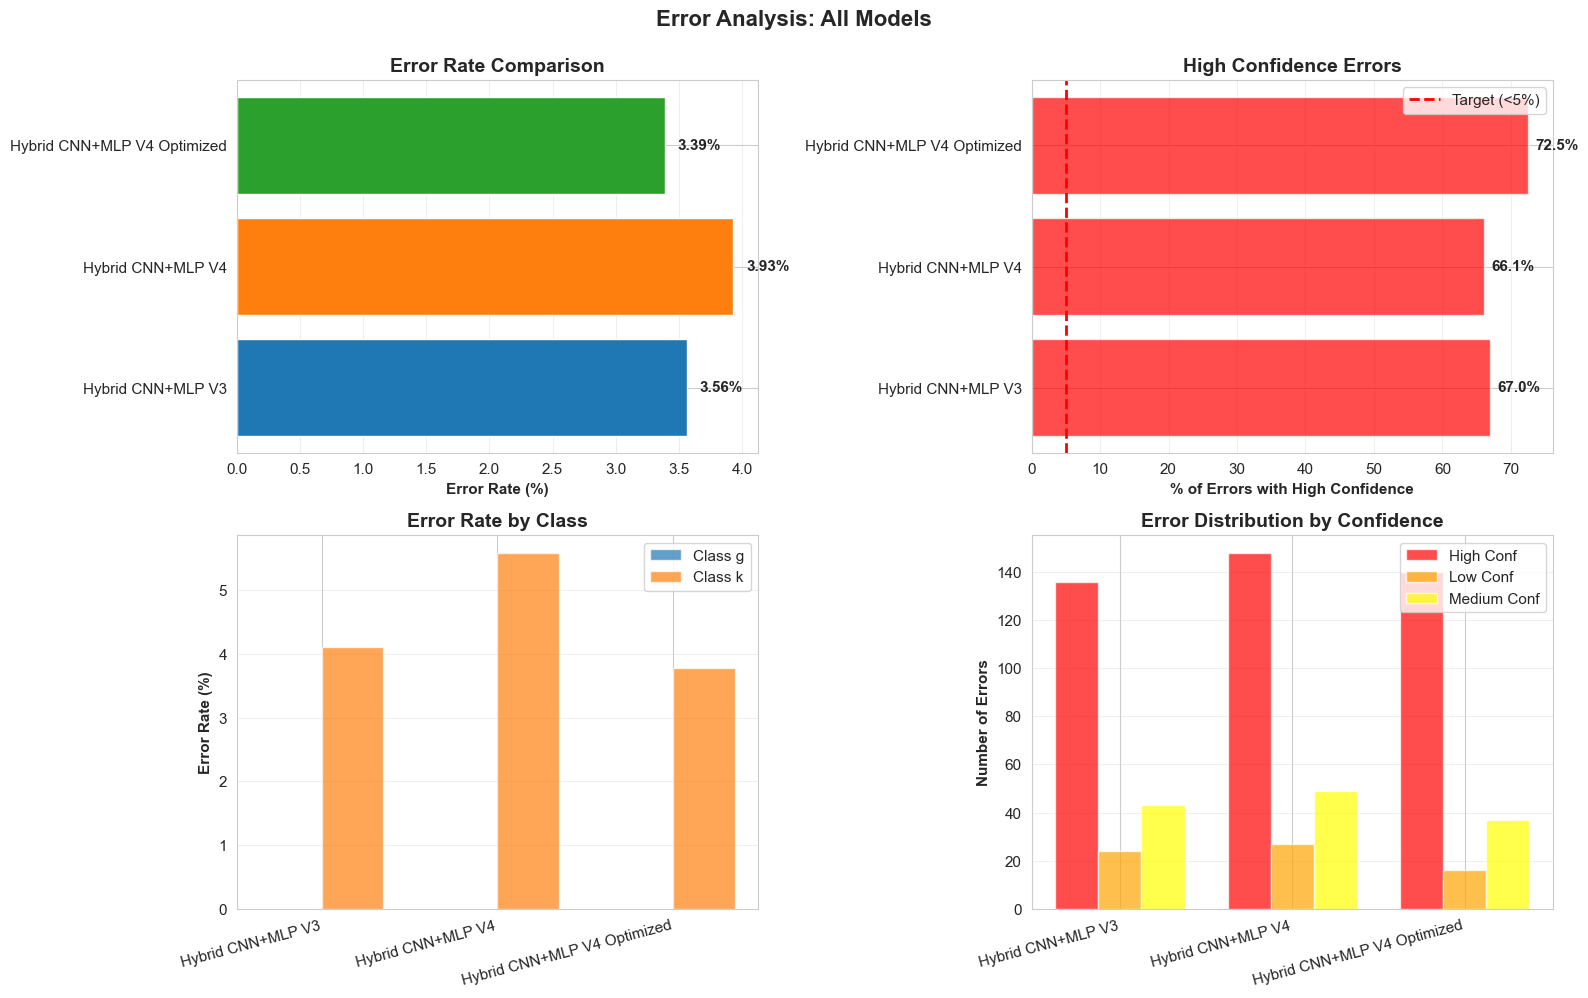

In [7]:
# Error analysis for all models
error_analysis_data = []

for model_key, predictions_df in all_predictions.items():
    total = len(predictions_df)
    errors = (~predictions_df['is_correct'].astype(bool)).sum()
    error_rate = errors / total
    
    # High confidence errors (>0.8)
    high_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] > 0.8)).sum()
    high_conf_error_pct = (high_conf_errors / errors * 100) if errors > 0 else 0
    
    # Low confidence errors (<0.6)
    low_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] < 0.6)).sum()
    low_conf_error_pct = (low_conf_errors / errors * 100) if errors > 0 else 0
    
    # Errors by class
    errors_by_class = {}
    for class_label in [CLASS_0, CLASS_1]:
        class_errors = ((predictions_df['true_class'] == class_label) & 
                       (predictions_df['is_correct'] == 0)).sum()
        class_total = (predictions_df['true_class'] == class_label).sum()
        errors_by_class[class_label] = {
            'count': class_errors,
            'total': class_total,
            'rate': (class_errors / class_total * 100) if class_total > 0 else 0
        }
    
    error_analysis_data.append({
        'Model': MODELS_CONFIG[model_key]['name'],
        'Total Errors': errors,
        'Error Rate %': error_rate * 100,
        'High Conf Errors': high_conf_errors,
        'High Conf Errors %': high_conf_error_pct,
        'Low Conf Errors': low_conf_errors,
        'Low Conf Errors %': low_conf_error_pct,
        f'Errors {CLASS_0}': errors_by_class[CLASS_0]['count'],
        f'Error Rate {CLASS_0} %': errors_by_class[CLASS_0]['rate'],
        f'Errors {CLASS_1}': errors_by_class[CLASS_1]['count'],
        f'Error Rate {CLASS_1} %': errors_by_class[CLASS_1]['rate']
    })

error_analysis_df = pd.DataFrame(error_analysis_data)

print("="*80)
print("ERROR ANALYSIS COMPARISON")
print("="*80)
print("\n" + error_analysis_df.to_string(index=False))

# Visualize error analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Error rates
ax1 = axes[0, 0]
bars = ax1.barh(error_analysis_df['Model'], error_analysis_df['Error Rate %'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(error_analysis_df)])
ax1.set_xlabel('Error Rate (%)', fontweight='bold')
ax1.set_title('Error Rate Comparison', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, rate) in enumerate(zip(bars, error_analysis_df['Error Rate %'])):
    ax1.text(rate + 0.1, i, f'{rate:.2f}%', va='center', fontweight='bold')

# 2. High confidence errors
ax2 = axes[0, 1]
bars = ax2.barh(error_analysis_df['Model'], error_analysis_df['High Conf Errors %'],
                color='red', alpha=0.7)
ax2.set_xlabel('% of Errors with High Confidence', fontweight='bold')
ax2.set_title('High Confidence Errors', fontweight='bold', fontsize=14)
ax2.axvline(5, color='red', linestyle='--', linewidth=2, label='Target (<5%)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, pct) in enumerate(zip(bars, error_analysis_df['High Conf Errors %'])):
    ax2.text(pct + 1, i, f'{pct:.1f}%', va='center', fontweight='bold')

# 3. Error rates by class
ax3 = axes[1, 0]
x = np.arange(len(error_analysis_df))
width = 0.35
bars1 = ax3.bar(x - width/2, error_analysis_df[f'Error Rate {CLASS_0} %'], width,
               label=f'Class {CLASS_0}', alpha=0.7)
bars2 = ax3.bar(x + width/2, error_analysis_df[f'Error Rate {CLASS_1} %'], width,
               label=f'Class {CLASS_1}', alpha=0.7)
ax3.set_ylabel('Error Rate (%)', fontweight='bold')
ax3.set_title('Error Rate by Class', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error distribution
ax4 = axes[1, 1]
x = np.arange(len(error_analysis_df))
width = 0.25
ax4.bar(x - width, error_analysis_df['High Conf Errors'], width,
       label='High Conf', color='red', alpha=0.7)
ax4.bar(x, error_analysis_df['Low Conf Errors'], width,
       label='Low Conf', color='orange', alpha=0.7)
ax4.bar(x + width, error_analysis_df['Total Errors'] - 
       error_analysis_df['High Conf Errors'] - error_analysis_df['Low Conf Errors'], width,
       label='Medium Conf', color='yellow', alpha=0.7)
ax4.set_ylabel('Number of Errors', fontweight='bold')
ax4.set_title('Error Distribution by Confidence', fontweight='bold', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Error Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Part 6: Classical ML Models Comparison


CLASSICAL ML MODELS COMPARISON

             Model  Accuracy  F1-Score  Precision   Recall  ROC-AUC
          Stacking  0.960161  0.960177   0.960202 0.960161 0.992260
           SVM_RBF  0.959459  0.959418   0.959443 0.959459 0.991886
       Voting_Soft  0.950684  0.950680   0.950676 0.950684 0.989483
          Blending  0.950684  0.950680   0.950676 0.950684 0.989527
       Voting_Hard  0.949456  0.949468   0.949484 0.949456      NaN
           XGBoost  0.946297  0.946375   0.946614 0.946297 0.986901
          LightGBM  0.944717  0.944785   0.944962 0.944717 0.986100
  GradientBoosting  0.944015  0.943955   0.943968 0.944015 0.985420
          CatBoost  0.933485  0.933208   0.933836 0.933485 0.981519
      RandomForest  0.915233  0.915120   0.915114 0.915233 0.973183
LogisticRegression  0.908915  0.909036   0.909282 0.908915 0.966882
        ExtraTrees  0.903475  0.903446   0.903423 0.903475 0.965428


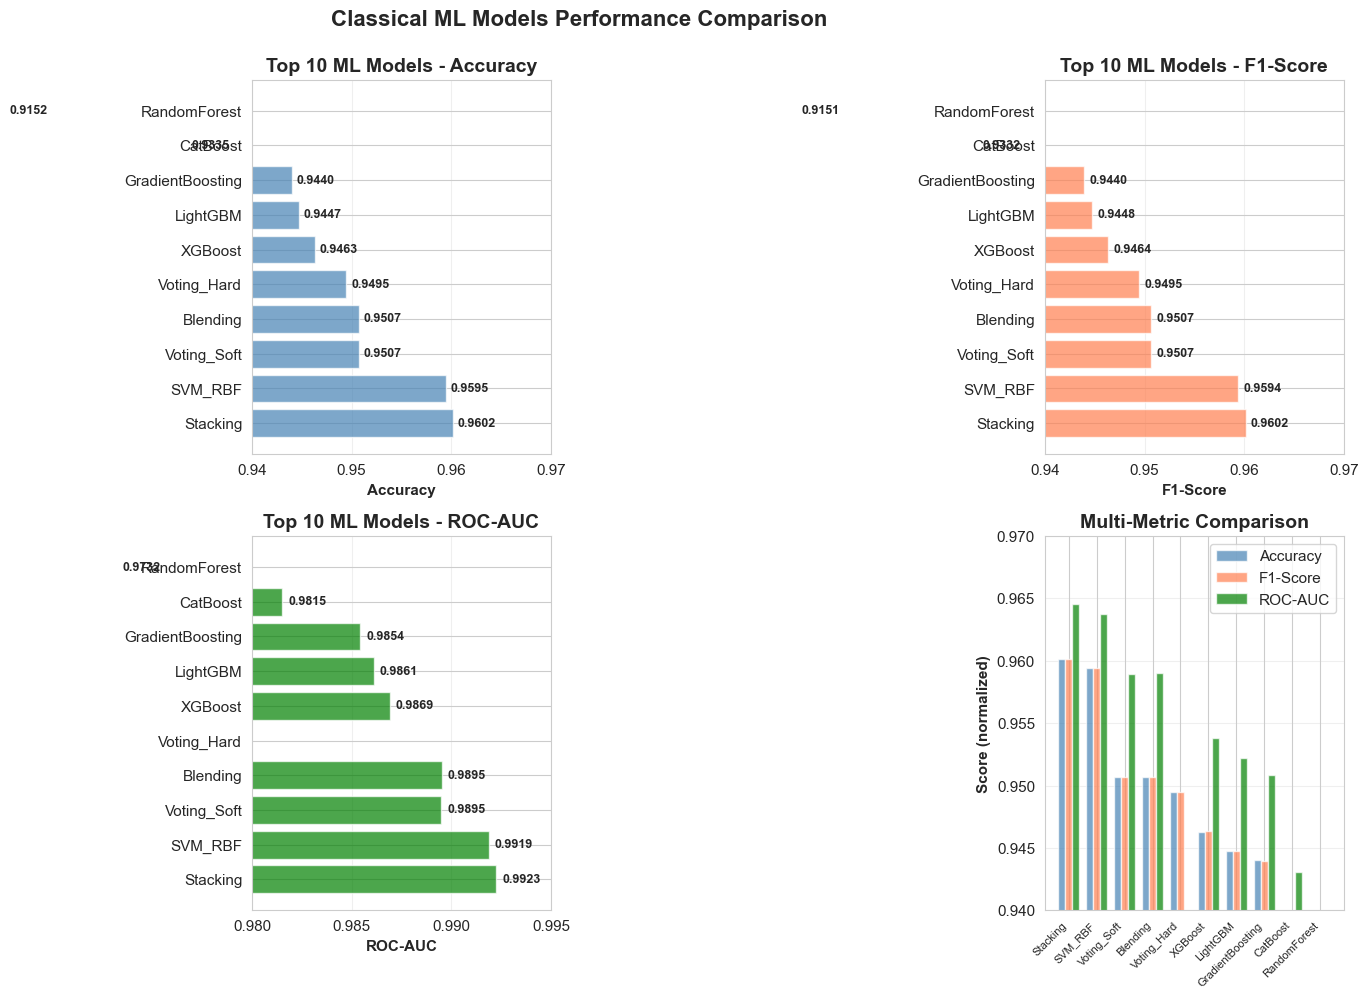


BEST ML MODEL: Stacking
Accuracy: 0.9602
F1-Score: 0.9602
ROC-AUC: 0.9923


In [8]:
# Display ML models comparison if available
if 'ml_results_df' in locals() and len(ml_results_df) > 0:
    print("="*80)
    print("CLASSICAL ML MODELS COMPARISON")
    print("="*80)
    
    # Select relevant columns
    ml_display = ml_results_df[['model_name', 'test_accuracy', 'test_f1_weighted', 
                                'test_precision', 'test_recall', 'test_roc_auc']].copy()
    ml_display = ml_display.sort_values('test_f1_weighted', ascending=False)
    ml_display.columns = ['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
    
    print("\n" + ml_display.to_string(index=False))
    
    # Visualize top ML models
    top_ml = ml_display.head(10)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Accuracy
    ax1 = axes[0, 0]
    bars = ax1.barh(top_ml['Model'], top_ml['Accuracy'], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Accuracy', fontweight='bold')
    ax1.set_title('Top 10 ML Models - Accuracy', fontweight='bold', fontsize=14)
    ax1.set_xlim([0.94, 0.97])
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (bar, acc) in enumerate(zip(bars, top_ml['Accuracy'])):
        ax1.text(acc + 0.0005, i, f'{acc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 2. F1-Score
    ax2 = axes[0, 1]
    bars = ax2.barh(top_ml['Model'], top_ml['F1-Score'], color='coral', alpha=0.7)
    ax2.set_xlabel('F1-Score', fontweight='bold')
    ax2.set_title('Top 10 ML Models - F1-Score', fontweight='bold', fontsize=14)
    ax2.set_xlim([0.94, 0.97])
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (bar, f1) in enumerate(zip(bars, top_ml['F1-Score'])):
        ax2.text(f1 + 0.0005, i, f'{f1:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 3. ROC-AUC
    ax3 = axes[1, 0]
    bars = ax3.barh(top_ml['Model'], top_ml['ROC-AUC'], color='green', alpha=0.7)
    ax3.set_xlabel('ROC-AUC', fontweight='bold')
    ax3.set_title('Top 10 ML Models - ROC-AUC', fontweight='bold', fontsize=14)
    ax3.set_xlim([0.98, 0.995])
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (bar, roc) in enumerate(zip(bars, top_ml['ROC-AUC'])):
        if not pd.isna(roc):
            ax3.text(roc + 0.0003, i, f'{roc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 4. Multi-metric comparison
    ax4 = axes[1, 1]
    x = np.arange(len(top_ml))
    width = 0.25
    metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
    colors_ml = ['steelblue', 'coral', 'green']
    for idx, (metric, color) in enumerate(zip(metrics, colors_ml)):
        values = top_ml[metric].values
        if metric == 'ROC-AUC':
            # Normalize for visualization
            values = 0.94 + (values - 0.98) * (0.03 / 0.015) if not pd.isna(values).all() else values
        ax4.bar(x + idx*width, values, width, label=metric, color=color, alpha=0.7)
    ax4.set_ylabel('Score (normalized)', fontweight='bold')
    ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(top_ml['Model'], rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.set_ylim([0.94, 0.97])
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Classical ML Models Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"BEST ML MODEL: {top_ml.iloc[0]['Model']}")
    print(f"{'='*80}")
    print(f"Accuracy: {top_ml.iloc[0]['Accuracy']:.4f}")
    print(f"F1-Score: {top_ml.iloc[0]['F1-Score']:.4f}")
    print(f"ROC-AUC: {top_ml.iloc[0]['ROC-AUC']:.4f}")
else:
    print("ML models results not available")


## Part 7: Final Summary and Recommendations


In [9]:
print("="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Overall best model
print(f"\n🏆 OVERALL BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

# Performance ranking
print(f"\n📊 PERFORMANCE RANKING (by Accuracy):")
for idx, row in comparison_df.iterrows():
    rank = idx + 1
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
    print(f"   {medal} {row['Model']}: {row['Accuracy']:.4f} (F1: {row['F1-Score']:.4f}, ROC-AUC: {row['ROC-AUC']:.4f})")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   • Performance range: {comparison_df['Accuracy'].min():.4f} - {comparison_df['Accuracy'].max():.4f}")
print(f"   • Best F1-Score: {comparison_df['F1-Score'].max():.4f} ({comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']})")
print(f"   • Best ROC-AUC: {comparison_df['ROC-AUC'].max():.4f} ({comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']})")

# Error analysis summary
if len(error_analysis_df) > 0:
    print(f"\n⚠️  ERROR ANALYSIS:")
    best_error_model = error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmin()]
    print(f"   • Lowest error rate: {best_error_model['Error Rate %']:.2f}% ({best_error_model['Model']})")
    print(f"   • Highest error rate: {error_analysis_df['Error Rate %'].max():.2f}% ({error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmax(), 'Model']})")
    
    # High confidence errors
    worst_hce = error_analysis_df.loc[error_analysis_df['High Conf Errors %'].idxmax()]
    print(f"   • Most high-confidence errors: {worst_hce['High Conf Errors %']:.1f}% ({worst_hce['Model']})")

# Recommendations
print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Use {best_model['Model']} for production (best overall performance)")
print(f"   2. Monitor error rates and high-confidence errors in production")
print(f"   3. Consider ensemble methods combining top models for improved robustness")
if len(error_analysis_df) > 0:
    best_separation_model = None
    best_separation = 0
    for model_key, predictions_df in all_predictions.items():
        correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
        incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
        separation = correct_probs.mean() - incorrect_probs.mean()
        if separation > best_separation:
            best_separation = separation
            best_separation_model = MODELS_CONFIG[model_key]['name']
    if best_separation_model:
        print(f"   4. {best_separation_model} shows best probability separation (good for confidence-based filtering)")

print(f"\n{'='*80}")


FINAL SUMMARY AND RECOMMENDATIONS

🏆 OVERALL BEST MODEL: Hybrid CNN+MLP V4 Optimized
   Accuracy: 0.9661
   F1-Score: 0.9661
   ROC-AUC: 0.9859

📊 PERFORMANCE RANKING (by Accuracy):
   🥉 Hybrid CNN+MLP V4 Optimized: 0.9661 (F1: 0.9661, ROC-AUC: 0.9859)
   🥇 Hybrid CNN+MLP V3: 0.9644 (F1: 0.9644, ROC-AUC: 0.9846)
   🥈 Hybrid CNN+MLP V4: 0.9607 (F1: 0.9606, ROC-AUC: 0.9902)
   4. ML: Stacking: 0.9602 (F1: 0.9602, ROC-AUC: 0.9923)

💡 KEY INSIGHTS:
   • Performance range: 0.9602 - 0.9661
   • Best F1-Score: 0.9661 (Hybrid CNN+MLP V4 Optimized)
   • Best ROC-AUC: 0.9923 (ML: Stacking)

⚠️  ERROR ANALYSIS:
   • Lowest error rate: 3.39% (Hybrid CNN+MLP V4 Optimized)
   • Highest error rate: 3.93% (Hybrid CNN+MLP V4)
   • Most high-confidence errors: 72.5% (Hybrid CNN+MLP V4 Optimized)

✅ RECOMMENDATIONS:
   1. Use Hybrid CNN+MLP V4 Optimized for production (best overall performance)
   2. Monitor error rates and high-confidence errors in production
   3. Consider ensemble methods combining to

# Comparative Analysis of All Models for b-p Pair

This notebook analyzes and compares results from all trained models for b-p phoneme classification:
- **Hybrid CNN+MLP V3** (from `03.1_b-p_improved_hybrid_cnn_mlp_with_context.ipynb`)
- **Hybrid CNN+MLP V4** (from `03.2_b-p_improved_hybrid_cnn_mlp_v4_with_context.ipynb`)
- **Hybrid CNN+MLP V4 Optimized** (from `03.2.2_b-p_improved_hybrid_cnn_mlp_v4_optimized.ipynb`)
- **Classical ML Models** (from `03.3_ML_b-p_classification.ipynb`)

For each model, we will:
1. Load predictions and metrics
2. Create confusion matrices
3. Compare performance metrics across models
4. Analyze probability distributions
5. Identify best performing model


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, brier_score_loss
from sklearn.calibration import calibration_curve
import json
import warnings
warnings.filterwarnings('ignore')

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Project root
PROJECT_ROOT = Path('/Volumes/SSanDisk/SpeechRec-German')

# Define paths for all models
MODELS_CONFIG = {
    'V3': {
        'name': 'Hybrid CNN+MLP V3',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context' / 'improved_models' / 'hybrid_cnn_mlp_v3_with_context' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context' / 'features' / 'features.parquet'
    },
    'V4': {
        'name': 'Hybrid CNN+MLP V4',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context_v2' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_with_context_v2' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'V4_Optimized': {
        'name': 'Hybrid CNN+MLP V4 Optimized',
        'type': 'deep_learning',
        'predictions_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_predictions_with_probs.csv',
        'metrics_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'improved_models' / 'hybrid_cnn_mlp_v4_2_optimized' / 'test_metrics.json',
        'features_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'features' / 'features.parquet'
    },
    'ML_Models': {
        'name': 'Classical ML Models',
        'type': 'machine_learning',
        'results_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'ml_results' / 'all_results.json',
        'results_csv_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'ml_results' / 'all_results.csv',
        'features_path': PROJECT_ROOT / 'artifacts' / 'b-p_dl_models_with_context_v2' / 'features' / 'features.parquet'
    }
}

# Class labels for b-p pair
CLASS_0 = 'b'
CLASS_1 = 'p'

print("Configuration loaded successfully!")
print(f"\nAnalyzing {len(MODELS_CONFIG)} model groups:")
for model_key, config in MODELS_CONFIG.items():
    print(f"  - {config['name']} ({config['type']})")


Configuration loaded successfully!

Analyzing 4 model groups:
  - Hybrid CNN+MLP V3 (deep_learning)
  - Hybrid CNN+MLP V4 (deep_learning)
  - Hybrid CNN+MLP V4 Optimized (deep_learning)
  - Classical ML Models (machine_learning)


## Part 1: Load Data for All Models


In [ ]:
# Load data for all deep learning models
all_predictions = {}
all_metrics = {}

print("="*80)
print("LOADING DATA FOR ALL MODELS")
print("="*80)

# Load Deep Learning models
for model_key, config in MODELS_CONFIG.items():
    if config['type'] == 'deep_learning':
        print(f"\nLoading {config['name']}...")
        try:
            # Load predictions
            if config['predictions_path'].exists():
                predictions_df = pd.read_csv(config['predictions_path'])
                all_predictions[model_key] = predictions_df
                print(f"  ✓ Loaded {len(predictions_df)} predictions")
                print(f"    Correct: {predictions_df['is_correct'].sum()}, Incorrect: {(~predictions_df['is_correct'].astype(bool)).sum()}")
            else:
                print(f"  ✗ Predictions file not found: {config['predictions_path']}")
                continue
            
            # Load metrics
            if config['metrics_path'].exists():
                with open(config['metrics_path'], 'r') as f:
                    metrics = json.load(f)
                all_metrics[model_key] = metrics
                print(f"  ✓ Loaded metrics:")
                print(f"    Accuracy: {metrics['accuracy']:.4f}, F1: {metrics['f1']:.4f}, ROC-AUC: {metrics['roc_auc']:.4f}")
            else:
                print(f"  ✗ Metrics file not found: {config['metrics_path']}")
        except Exception as e:
            print(f"  ✗ Error loading {config['name']}: {e}")

# Load ML models results
print(f"\nLoading {MODELS_CONFIG['ML_Models']['name']}...")
try:
    if MODELS_CONFIG['ML_Models']['results_path'].exists():
        with open(MODELS_CONFIG['ML_Models']['results_path'], 'r') as f:
            ml_results = json.load(f)
        all_metrics['ML_Models'] = ml_results
        print(f"  ✓ Loaded results for {len(ml_results)} ML models")
        
        # Load CSV for detailed analysis
        if MODELS_CONFIG['ML_Models']['results_csv_path'].exists():
            ml_results_df = pd.read_csv(MODELS_CONFIG['ML_Models']['results_csv_path'])
            print(f"  ✓ Loaded detailed results CSV")
    else:
        print(f"  ✗ ML results file not found: {MODELS_CONFIG['ML_Models']['results_path']}")
except Exception as e:
    print(f"  ✗ Error loading ML models: {e}")

print(f"\n{'='*80}")
print(f"Successfully loaded {len(all_predictions)} deep learning models and {1 if 'ML_Models' in all_metrics else 0} ML model group")
print(f"{'='*80}")


LOADING DATA FOR ALL MODELS

Loading Hybrid CNN+MLP V3...
  ✓ Loaded 5536 predictions
    Correct: 5344, Incorrect: 192
  ✓ Loaded metrics:
    Accuracy: 0.9653, F1: 0.9654, ROC-AUC: 0.9903

Loading Hybrid CNN+MLP V4...
  ✓ Loaded 5536 predictions
    Correct: 5327, Incorrect: 209
  ✓ Loaded metrics:
    Accuracy: 0.9622, F1: 0.9623, ROC-AUC: 0.9905

Loading Hybrid CNN+MLP V4 Optimized...
  ✓ Loaded 5536 predictions
    Correct: 5348, Incorrect: 188
  ✓ Loaded metrics:
    Accuracy: 0.9660, F1: 0.9659, ROC-AUC: 0.9834

Loading Classical ML Models...
  ✓ Loaded results for 12 ML models
  ✓ Loaded detailed results CSV

Successfully loaded 3 deep learning models and 1 ML model group


## Part 2: Comparative Performance Analysis


In [ ]:
# Create comparison dataframe for all models
comparison_data = []

# Add Deep Learning models
for model_key, metrics in all_metrics.items():
    if model_key != 'ML_Models':
        comparison_data.append({
            'Model': MODELS_CONFIG[model_key]['name'],
            'Type': 'Deep Learning',
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'ROC-AUC': metrics['roc_auc'],
            'Precision_b': metrics.get('precision_b', metrics.get('precision_per_class', [0, 0])[0]),
            'Precision_p': metrics.get('precision_p', metrics.get('precision_per_class', [0, 0])[1]),
            'Recall_b': metrics.get('recall_b', metrics.get('recall_per_class', [0, 0])[0]),
            'Recall_p': metrics.get('recall_p', metrics.get('recall_per_class', [0, 0])[1]),
            'F1_b': metrics.get('f1_b', metrics.get('f1_per_class', [0, 0])[0]),
            'F1_p': metrics.get('f1_p', metrics.get('f1_per_class', [0, 0])[1])
        })

# Add best ML model
if 'ML_Models' in all_metrics and 'ml_results_df' in locals():
    best_ml = ml_results_df.iloc[0]  # Already sorted by test_f1_weighted
    comparison_data.append({
        'Model': f"ML: {best_ml['model_name']}",
        'Type': 'Machine Learning',
        'Accuracy': best_ml['test_accuracy'],
        'F1-Score': best_ml['test_f1_weighted'],
        'Precision': best_ml['test_precision'],
        'Recall': best_ml['test_recall'],
        'ROC-AUC': best_ml.get('test_roc_auc', np.nan),
        'Precision_b': np.nan,
        'Precision_p': np.nan,
        'Recall_b': np.nan,
        'Recall_p': np.nan,
        'F1_b': np.nan,
        'F1_p': np.nan
    })

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Accuracy', ascending=False)

print("="*80)
print("PERFORMANCE COMPARISON ACROSS ALL MODELS")
print("="*80)
print("\n" + comparison_df.to_string(index=False))

# Find best model
best_model = comparison_df.iloc[0]
print(f"\n{'='*80}")
print(f"BEST MODEL: {best_model['Model']}")
print(f"{'='*80}")
print(f"Accuracy: {best_model['Accuracy']:.4f}")
print(f"F1-Score: {best_model['F1-Score']:.4f}")
print(f"ROC-AUC: {best_model['ROC-AUC']:.4f}")


PERFORMANCE COMPARISON ACROSS ALL MODELS

                      Model             Type  Accuracy  F1-Score  Precision   Recall  ROC-AUC  Precision_b  Precision_p  Recall_b  Recall_p     F1_b     F1_p
Hybrid CNN+MLP V4 Optimized    Deep Learning  0.966040  0.965950   0.965927 0.966040 0.983379     0.972180     0.951174  0.979681  0.933859 0.975916 0.942437
          Hybrid CNN+MLP V3    Deep Learning  0.965318  0.965386   0.965489 0.965318 0.990336     0.978138     0.935073  0.972634  0.947724 0.975378 0.941356
          Hybrid CNN+MLP V4    Deep Learning  0.962247  0.962316   0.962416 0.962247 0.990506     0.975692     0.931096  0.970422  0.942961 0.973050 0.936991
                ML: SVM_RBF Machine Learning  0.962247  0.962177   0.962140 0.962247 0.989616          NaN          NaN       NaN       NaN      NaN      NaN

BEST MODEL: Hybrid CNN+MLP V4 Optimized
Accuracy: 0.9660
F1-Score: 0.9659
ROC-AUC: 0.9834


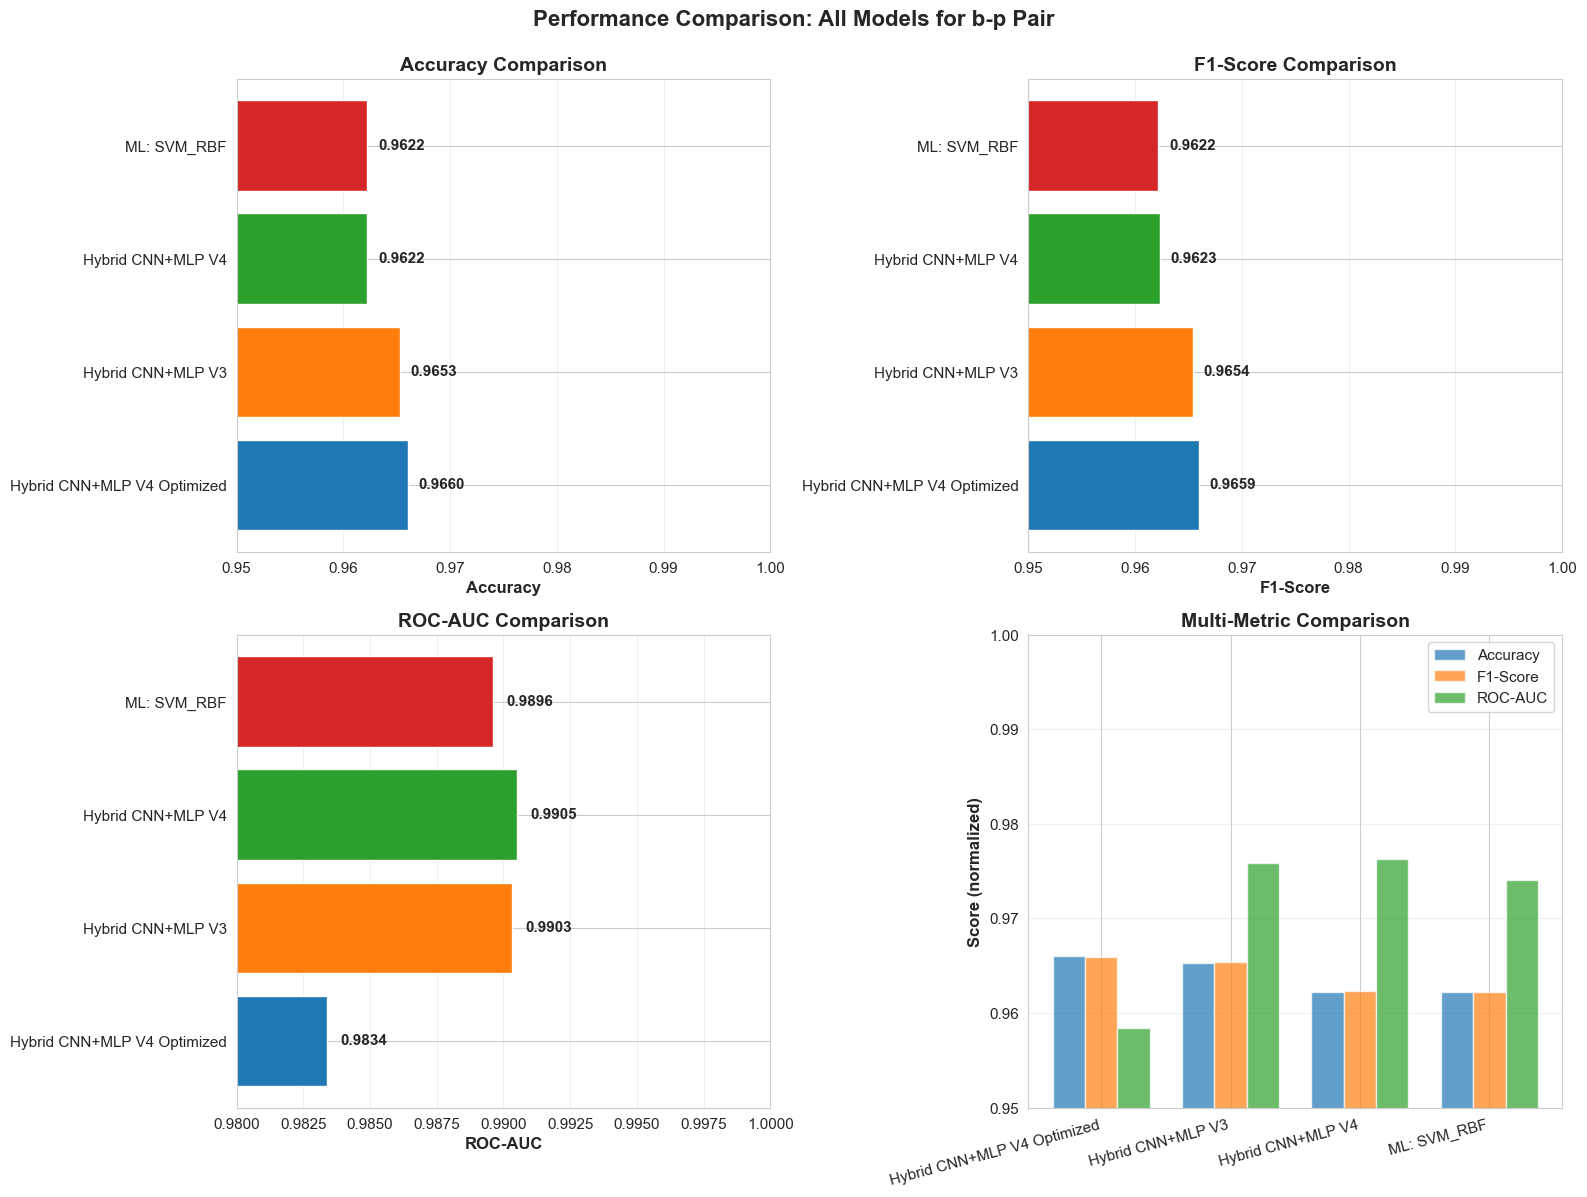

In [ ]:
# Visualize performance comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Accuracy comparison
ax1 = axes[0, 0]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
bars = ax1.barh(comparison_df['Model'], comparison_df['Accuracy'], color=colors[:len(comparison_df)])
ax1.set_xlabel('Accuracy', fontweight='bold', fontsize=12)
ax1.set_title('Accuracy Comparison', fontweight='bold', fontsize=14)
ax1.set_xlim([0.95, 1.0])
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, acc) in enumerate(zip(bars, comparison_df['Accuracy'])):
    ax1.text(acc + 0.001, i, f'{acc:.4f}', va='center', fontweight='bold')

# 2. F1-Score comparison
ax2 = axes[0, 1]
bars = ax2.barh(comparison_df['Model'], comparison_df['F1-Score'], color=colors[:len(comparison_df)])
ax2.set_xlabel('F1-Score', fontweight='bold', fontsize=12)
ax2.set_title('F1-Score Comparison', fontweight='bold', fontsize=14)
ax2.set_xlim([0.95, 1.0])
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, f1) in enumerate(zip(bars, comparison_df['F1-Score'])):
    ax2.text(f1 + 0.001, i, f'{f1:.4f}', va='center', fontweight='bold')

# 3. ROC-AUC comparison
ax3 = axes[1, 0]
bars = ax3.barh(comparison_df['Model'], comparison_df['ROC-AUC'], color=colors[:len(comparison_df)])
ax3.set_xlabel('ROC-AUC', fontweight='bold', fontsize=12)
ax3.set_title('ROC-AUC Comparison', fontweight='bold', fontsize=14)
ax3.set_xlim([0.98, 1.0])
ax3.grid(True, alpha=0.3, axis='x')
for i, (bar, roc) in enumerate(zip(bars, comparison_df['ROC-AUC'])):
    if not pd.isna(roc):
        ax3.text(roc + 0.0005, i, f'{roc:.4f}', va='center', fontweight='bold')

# 4. Multi-metric radar chart (simplified as grouped bar)
ax4 = axes[1, 1]
x = np.arange(len(comparison_df))
width = 0.25
metrics_to_plot = ['Accuracy', 'F1-Score', 'ROC-AUC']
for idx, metric in enumerate(metrics_to_plot):
    values = comparison_df[metric].values
    # Normalize ROC-AUC for comparison (scale to 0.95-1.0 range)
    if metric == 'ROC-AUC':
        values = 0.95 + (values - 0.98) * (0.05 / 0.02) if not pd.isna(values).all() else values
    ax4.bar(x + idx*width, values, width, label=metric, alpha=0.7)
ax4.set_ylabel('Score (normalized)', fontweight='bold', fontsize=12)
ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
ax4.set_xticks(x + width)
ax4.set_xticklabels(comparison_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.set_ylim([0.95, 1.0])
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Performance Comparison: All Models for b-p Pair', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


## Part 3: Confusion Matrices for All Deep Learning Models


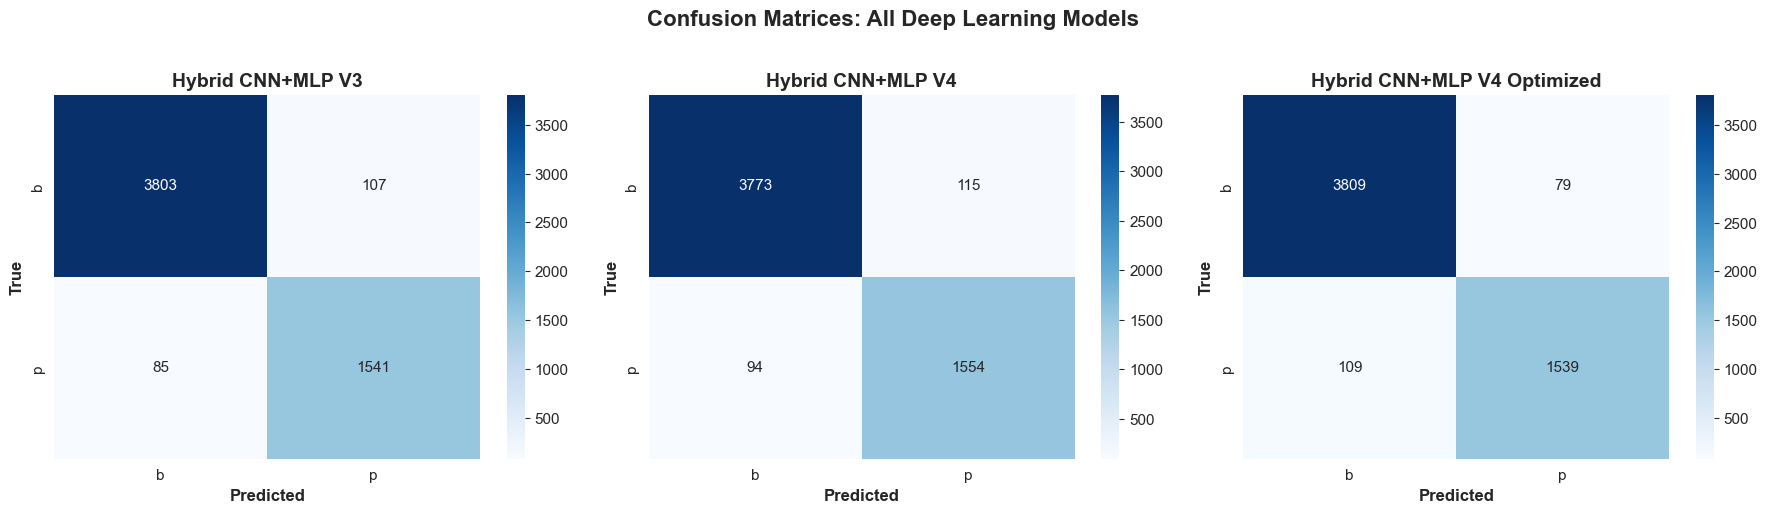

CLASSIFICATION REPORTS

Hybrid CNN+MLP V3:
------------------------------------------------------------
              precision    recall  f1-score   support

           b     0.9781    0.9726    0.9754      3910
           p     0.9351    0.9477    0.9414      1626

    accuracy                         0.9653      5536
   macro avg     0.9566    0.9602    0.9584      5536
weighted avg     0.9655    0.9653    0.9654      5536


Hybrid CNN+MLP V4:
------------------------------------------------------------
              precision    recall  f1-score   support

           b     0.9757    0.9704    0.9730      3888
           p     0.9311    0.9430    0.9370      1648

    accuracy                         0.9622      5536
   macro avg     0.9534    0.9567    0.9550      5536
weighted avg     0.9624    0.9622    0.9623      5536


Hybrid CNN+MLP V4 Optimized:
------------------------------------------------------------
              precision    recall  f1-score   support

           b   

In [ ]:
# Create confusion matrices for all deep learning models
n_models = len(all_predictions)
fig, axes = plt.subplots(1, n_models, figsize=(6*n_models, 5))

if n_models == 1:
    axes = [axes]

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    ax = axes[idx]
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    cm = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=[CLASS_0, CLASS_1],
                yticklabels=[CLASS_0, CLASS_1])
    ax.set_xlabel('Predicted', fontsize=12, fontweight='bold')
    ax.set_ylabel('True', fontsize=12, fontweight='bold')
    ax.set_title(f'{MODELS_CONFIG[model_key]["name"]}', fontsize=14, fontweight='bold')

plt.suptitle('Confusion Matrices: All Deep Learning Models', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print classification reports
print("="*80)
print("CLASSIFICATION REPORTS")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print("-" * 60)
    y_true = predictions_df['true_class_encoded'].values
    y_pred = predictions_df['predicted_class_encoded'].values
    print(classification_report(y_true, y_pred, 
                                target_names=[CLASS_0, CLASS_1],
                                digits=4))


## Part 4: Probability Distribution Analysis


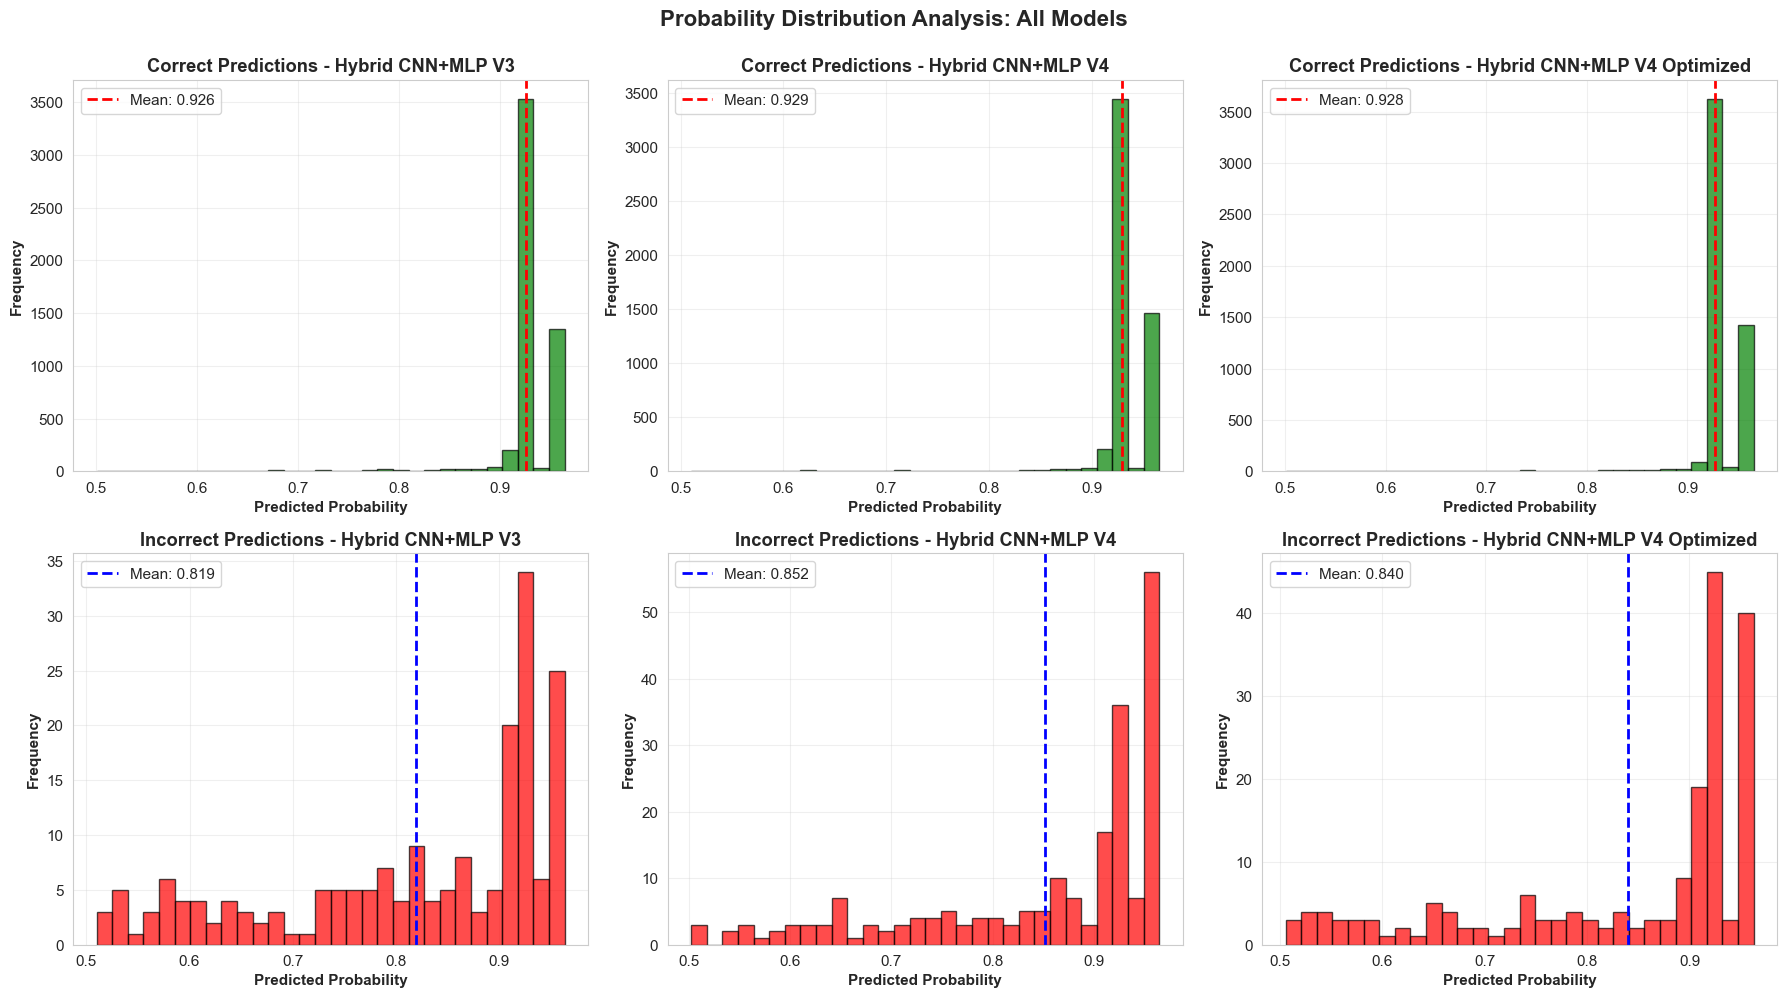

PROBABILITY STATISTICS COMPARISON

Hybrid CNN+MLP V3:
  Correct predictions:
    Mean: 0.9259, Median: 0.9223, Std: 0.0412
  Incorrect predictions:
    Mean: 0.8195, Median: 0.8646, Std: 0.1323
  Separation: 0.1064

Hybrid CNN+MLP V4:
  Correct predictions:
    Mean: 0.9293, Median: 0.9234, Std: 0.0380
  Incorrect predictions:
    Mean: 0.8522, Median: 0.9135, Std: 0.1240
  Separation: 0.0771

Hybrid CNN+MLP V4 Optimized:
  Correct predictions:
    Mean: 0.9278, Median: 0.9229, Std: 0.0402
  Incorrect predictions:
    Mean: 0.8400, Median: 0.9144, Std: 0.1361
  Separation: 0.0878


In [ ]:
# Compare probability distributions across models
n_models = len(all_predictions)
fig, axes = plt.subplots(2, n_models, figsize=(6*n_models, 10))

if n_models == 1:
    axes = axes.reshape(2, 1)

for idx, (model_key, predictions_df) in enumerate(all_predictions.items()):
    # Top row: Correct predictions
    ax1 = axes[0, idx]
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    ax1.hist(correct_probs, bins=30, alpha=0.7, color='green', edgecolor='black')
    ax1.axvline(correct_probs.mean(), color='red', linestyle='--', linewidth=2, 
                label=f'Mean: {correct_probs.mean():.3f}')
    ax1.set_xlabel('Predicted Probability', fontweight='bold')
    ax1.set_ylabel('Frequency', fontweight='bold')
    ax1.set_title(f'Correct Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    # Bottom row: Incorrect predictions
    ax2 = axes[1, idx]
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    ax2.hist(incorrect_probs, bins=30, alpha=0.7, color='red', edgecolor='black')
    ax2.axvline(incorrect_probs.mean(), color='blue', linestyle='--', linewidth=2, 
                label=f'Mean: {incorrect_probs.mean():.3f}')
    ax2.set_xlabel('Predicted Probability', fontweight='bold')
    ax2.set_ylabel('Frequency', fontweight='bold')
    ax2.set_title(f'Incorrect Predictions - {MODELS_CONFIG[model_key]["name"]}', fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

plt.suptitle('Probability Distribution Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# Statistics comparison
print("="*80)
print("PROBABILITY STATISTICS COMPARISON")
print("="*80)
for model_key, predictions_df in all_predictions.items():
    correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
    incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
    
    print(f"\n{MODELS_CONFIG[model_key]['name']}:")
    print(f"  Correct predictions:")
    print(f"    Mean: {correct_probs.mean():.4f}, Median: {np.median(correct_probs):.4f}, Std: {correct_probs.std():.4f}")
    print(f"  Incorrect predictions:")
    print(f"    Mean: {incorrect_probs.mean():.4f}, Median: {np.median(incorrect_probs):.4f}, Std: {incorrect_probs.std():.4f}")
    print(f"  Separation: {correct_probs.mean() - incorrect_probs.mean():.4f}")


## Part 5: Error Analysis


ERROR ANALYSIS COMPARISON

                      Model  Total Errors  Error Rate %  High Conf Errors  High Conf Errors %  Low Conf Errors  Low Conf Errors %  Errors b  Error Rate b %  Errors p  Error Rate p %
          Hybrid CNN+MLP V3           192      3.468208               121           63.020833               22          11.458333       107        2.736573        85        5.227552
          Hybrid CNN+MLP V4           209      3.775289               152           72.727273               12           5.741627       115        2.957819        94        5.703883
Hybrid CNN+MLP V4 Optimized           188      3.395954               132           70.212766               21          11.170213        79        2.031893       109        6.614078


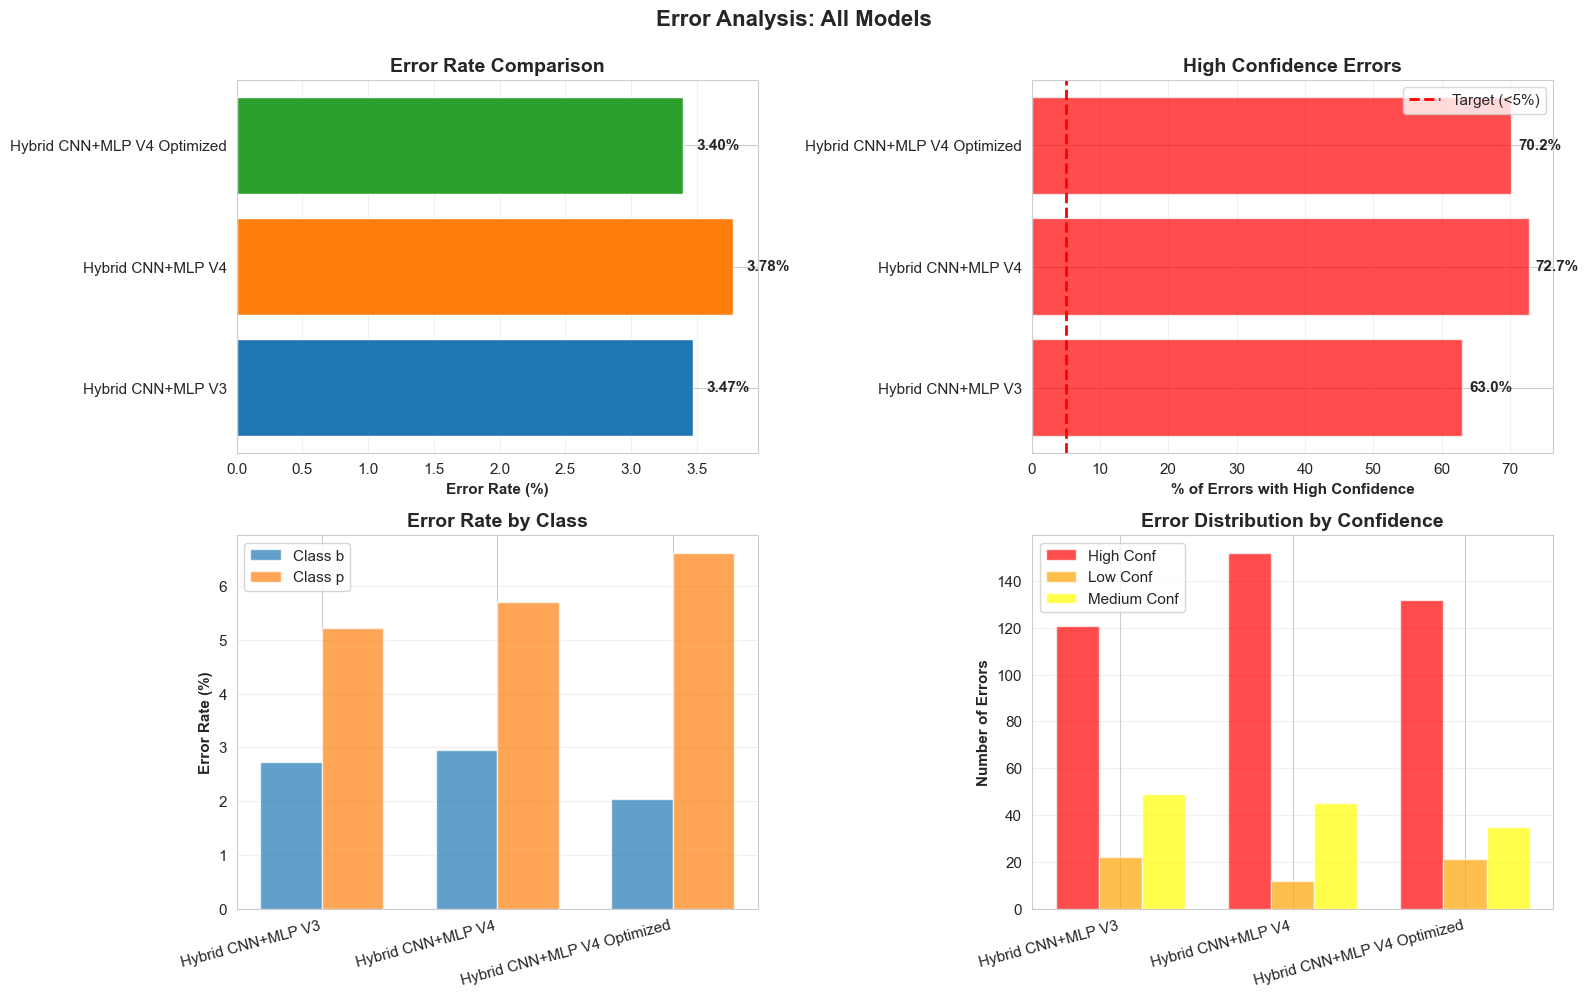

In [ ]:
# Error analysis for all models
error_analysis_data = []

for model_key, predictions_df in all_predictions.items():
    total = len(predictions_df)
    errors = (~predictions_df['is_correct'].astype(bool)).sum()
    error_rate = errors / total
    
    # High confidence errors (>0.8)
    high_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] > 0.8)).sum()
    high_conf_error_pct = (high_conf_errors / errors * 100) if errors > 0 else 0
    
    # Low confidence errors (<0.6)
    low_conf_errors = ((predictions_df['is_correct'] == 0) & (predictions_df['max_prob'] < 0.6)).sum()
    low_conf_error_pct = (low_conf_errors / errors * 100) if errors > 0 else 0
    
    # Errors by class
    errors_by_class = {}
    for class_label in [CLASS_0, CLASS_1]:
        class_errors = ((predictions_df['true_class'] == class_label) & 
                       (predictions_df['is_correct'] == 0)).sum()
        class_total = (predictions_df['true_class'] == class_label).sum()
        errors_by_class[class_label] = {
            'count': class_errors,
            'total': class_total,
            'rate': (class_errors / class_total * 100) if class_total > 0 else 0
        }
    
    error_analysis_data.append({
        'Model': MODELS_CONFIG[model_key]['name'],
        'Total Errors': errors,
        'Error Rate %': error_rate * 100,
        'High Conf Errors': high_conf_errors,
        'High Conf Errors %': high_conf_error_pct,
        'Low Conf Errors': low_conf_errors,
        'Low Conf Errors %': low_conf_error_pct,
        f'Errors {CLASS_0}': errors_by_class[CLASS_0]['count'],
        f'Error Rate {CLASS_0} %': errors_by_class[CLASS_0]['rate'],
        f'Errors {CLASS_1}': errors_by_class[CLASS_1]['count'],
        f'Error Rate {CLASS_1} %': errors_by_class[CLASS_1]['rate']
    })

error_analysis_df = pd.DataFrame(error_analysis_data)

print("="*80)
print("ERROR ANALYSIS COMPARISON")
print("="*80)
print("\n" + error_analysis_df.to_string(index=False))

# Visualize error analysis
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Error rates
ax1 = axes[0, 0]
bars = ax1.barh(error_analysis_df['Model'], error_analysis_df['Error Rate %'], 
                color=['#1f77b4', '#ff7f0e', '#2ca02c'][:len(error_analysis_df)])
ax1.set_xlabel('Error Rate (%)', fontweight='bold')
ax1.set_title('Error Rate Comparison', fontweight='bold', fontsize=14)
ax1.grid(True, alpha=0.3, axis='x')
for i, (bar, rate) in enumerate(zip(bars, error_analysis_df['Error Rate %'])):
    ax1.text(rate + 0.1, i, f'{rate:.2f}%', va='center', fontweight='bold')

# 2. High confidence errors
ax2 = axes[0, 1]
bars = ax2.barh(error_analysis_df['Model'], error_analysis_df['High Conf Errors %'],
                color='red', alpha=0.7)
ax2.set_xlabel('% of Errors with High Confidence', fontweight='bold')
ax2.set_title('High Confidence Errors', fontweight='bold', fontsize=14)
ax2.axvline(5, color='red', linestyle='--', linewidth=2, label='Target (<5%)')
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')
for i, (bar, pct) in enumerate(zip(bars, error_analysis_df['High Conf Errors %'])):
    ax2.text(pct + 1, i, f'{pct:.1f}%', va='center', fontweight='bold')

# 3. Error rates by class
ax3 = axes[1, 0]
x = np.arange(len(error_analysis_df))
width = 0.35
bars1 = ax3.bar(x - width/2, error_analysis_df[f'Error Rate {CLASS_0} %'], width,
               label=f'Class {CLASS_0}', alpha=0.7)
bars2 = ax3.bar(x + width/2, error_analysis_df[f'Error Rate {CLASS_1} %'], width,
               label=f'Class {CLASS_1}', alpha=0.7)
ax3.set_ylabel('Error Rate (%)', fontweight='bold')
ax3.set_title('Error Rate by Class', fontweight='bold', fontsize=14)
ax3.set_xticks(x)
ax3.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

# 4. Error distribution
ax4 = axes[1, 1]
x = np.arange(len(error_analysis_df))
width = 0.25
ax4.bar(x - width, error_analysis_df['High Conf Errors'], width,
       label='High Conf', color='red', alpha=0.7)
ax4.bar(x, error_analysis_df['Low Conf Errors'], width,
       label='Low Conf', color='orange', alpha=0.7)
ax4.bar(x + width, error_analysis_df['Total Errors'] - 
       error_analysis_df['High Conf Errors'] - error_analysis_df['Low Conf Errors'], width,
       label='Medium Conf', color='yellow', alpha=0.7)
ax4.set_ylabel('Number of Errors', fontweight='bold')
ax4.set_title('Error Distribution by Confidence', fontweight='bold', fontsize=14)
ax4.set_xticks(x)
ax4.set_xticklabels(error_analysis_df['Model'], rotation=15, ha='right')
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

plt.suptitle('Error Analysis: All Models', fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


CLASSICAL ML MODELS COMPARISON

             Model  Accuracy  F1-Score  Precision   Recall  ROC-AUC
           SVM_RBF  0.962247  0.962177   0.962140 0.962247 0.989616
          Stacking  0.961344  0.961520   0.961908 0.961344 0.989897
          Blending  0.952493  0.952595   0.952742 0.952493 0.987513
       Voting_Soft  0.952312  0.952419   0.952574 0.952312 0.987469
       Voting_Hard  0.948699  0.948866   0.949136 0.948699      NaN
           XGBoost  0.945629  0.945916   0.946485 0.945629 0.985052
  GradientBoosting  0.945990  0.945701   0.945668 0.945990 0.982924
          LightGBM  0.941113  0.941504   0.942344 0.941113 0.984200
          CatBoost  0.933345  0.934038   0.935867 0.933345 0.979658
      RandomForest  0.927565  0.927469   0.927389 0.927565 0.975259
LogisticRegression  0.911669  0.912867   0.916020 0.911669 0.964833
        ExtraTrees  0.906792  0.908088   0.911437 0.906792 0.967567


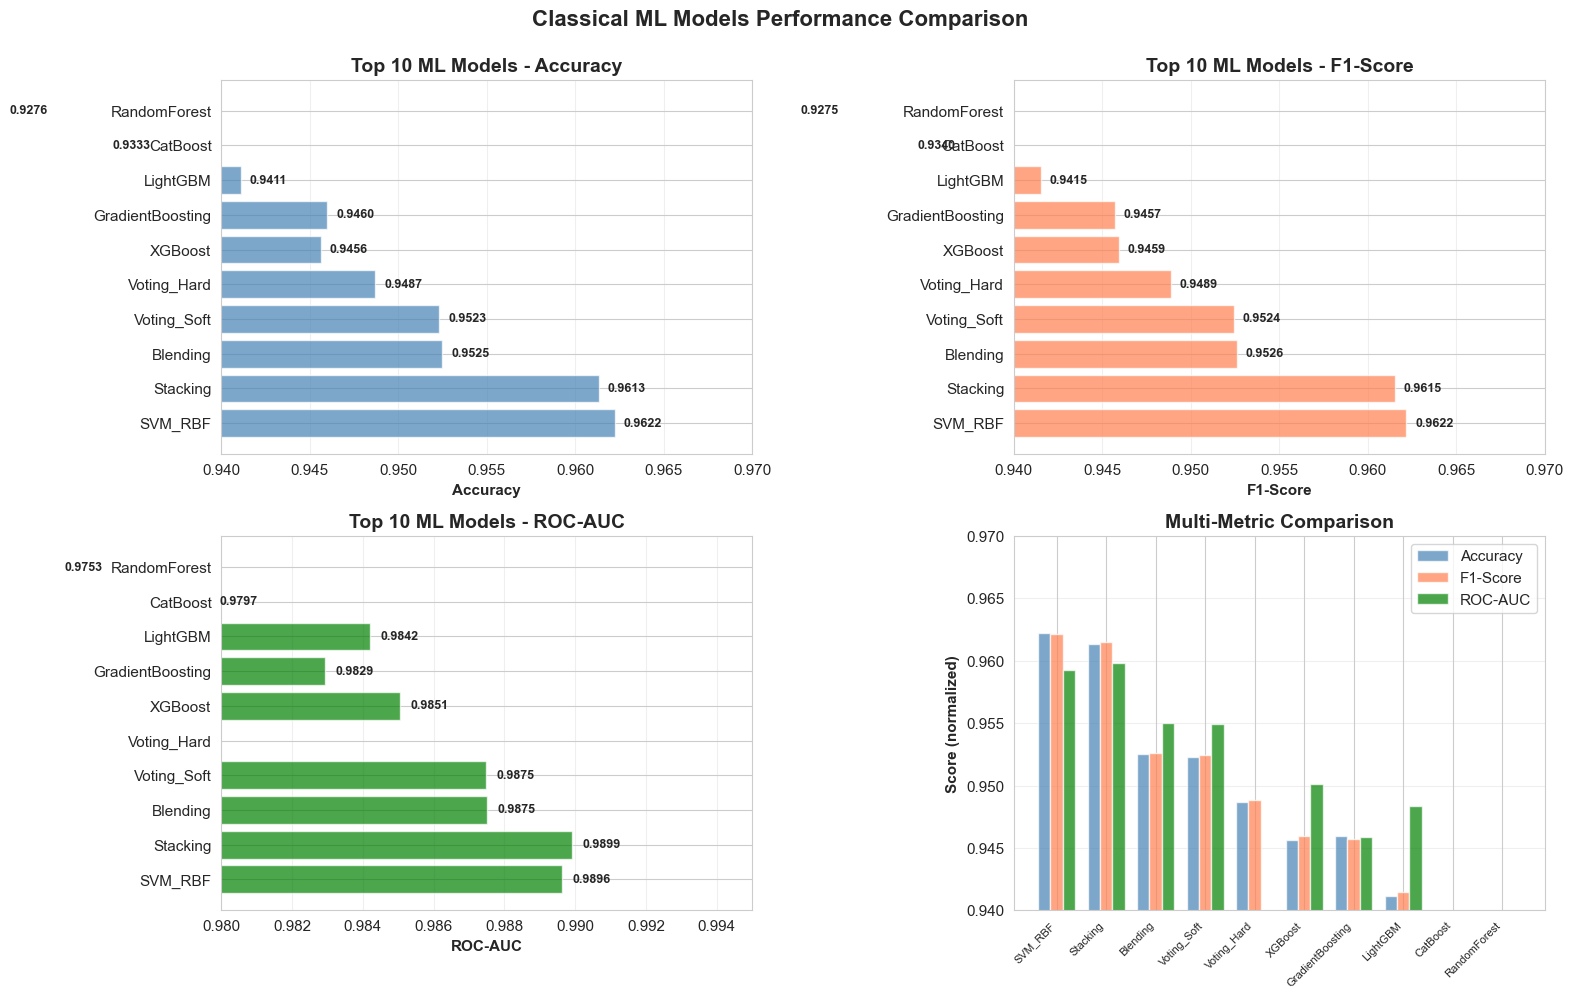


BEST ML MODEL: SVM_RBF
Accuracy: 0.9622
F1-Score: 0.9622
ROC-AUC: 0.9896


In [ ]:
# Display ML models comparison if available
if 'ml_results_df' in locals() and len(ml_results_df) > 0:
    print("="*80)
    print("CLASSICAL ML MODELS COMPARISON")
    print("="*80)
    
    # Select relevant columns
    ml_display = ml_results_df[['model_name', 'test_accuracy', 'test_f1_weighted', 
                                'test_precision', 'test_recall', 'test_roc_auc']].copy()
    ml_display = ml_display.sort_values('test_f1_weighted', ascending=False)
    ml_display.columns = ['Model', 'Accuracy', 'F1-Score', 'Precision', 'Recall', 'ROC-AUC']
    
    print("\n" + ml_display.to_string(index=False))
    
    # Visualize top ML models
    top_ml = ml_display.head(10)
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    
    # 1. Accuracy
    ax1 = axes[0, 0]
    bars = ax1.barh(top_ml['Model'], top_ml['Accuracy'], color='steelblue', alpha=0.7)
    ax1.set_xlabel('Accuracy', fontweight='bold')
    ax1.set_title('Top 10 ML Models - Accuracy', fontweight='bold', fontsize=14)
    ax1.set_xlim([0.94, 0.97])
    ax1.grid(True, alpha=0.3, axis='x')
    for i, (bar, acc) in enumerate(zip(bars, top_ml['Accuracy'])):
        ax1.text(acc + 0.0005, i, f'{acc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 2. F1-Score
    ax2 = axes[0, 1]
    bars = ax2.barh(top_ml['Model'], top_ml['F1-Score'], color='coral', alpha=0.7)
    ax2.set_xlabel('F1-Score', fontweight='bold')
    ax2.set_title('Top 10 ML Models - F1-Score', fontweight='bold', fontsize=14)
    ax2.set_xlim([0.94, 0.97])
    ax2.grid(True, alpha=0.3, axis='x')
    for i, (bar, f1) in enumerate(zip(bars, top_ml['F1-Score'])):
        ax2.text(f1 + 0.0005, i, f'{f1:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 3. ROC-AUC
    ax3 = axes[1, 0]
    bars = ax3.barh(top_ml['Model'], top_ml['ROC-AUC'], color='green', alpha=0.7)
    ax3.set_xlabel('ROC-AUC', fontweight='bold')
    ax3.set_title('Top 10 ML Models - ROC-AUC', fontweight='bold', fontsize=14)
    ax3.set_xlim([0.98, 0.995])
    ax3.grid(True, alpha=0.3, axis='x')
    for i, (bar, roc) in enumerate(zip(bars, top_ml['ROC-AUC'])):
        if not pd.isna(roc):
            ax3.text(roc + 0.0003, i, f'{roc:.4f}', va='center', fontweight='bold', fontsize=9)
    
    # 4. Multi-metric comparison
    ax4 = axes[1, 1]
    x = np.arange(len(top_ml))
    width = 0.25
    metrics = ['Accuracy', 'F1-Score', 'ROC-AUC']
    colors_ml = ['steelblue', 'coral', 'green']
    for idx, (metric, color) in enumerate(zip(metrics, colors_ml)):
        values = top_ml[metric].values
        if metric == 'ROC-AUC':
            # Normalize for visualization
            values = 0.94 + (values - 0.98) * (0.03 / 0.015) if not pd.isna(values).all() else values
        ax4.bar(x + idx*width, values, width, label=metric, color=color, alpha=0.7)
    ax4.set_ylabel('Score (normalized)', fontweight='bold')
    ax4.set_title('Multi-Metric Comparison', fontweight='bold', fontsize=14)
    ax4.set_xticks(x + width)
    ax4.set_xticklabels(top_ml['Model'], rotation=45, ha='right', fontsize=8)
    ax4.legend()
    ax4.set_ylim([0.94, 0.97])
    ax4.grid(True, alpha=0.3, axis='y')
    
    plt.suptitle('Classical ML Models Performance Comparison', fontsize=16, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()
    
    print(f"\n{'='*80}")
    print(f"BEST ML MODEL: {top_ml.iloc[0]['Model']}")
    print(f"{'='*80}")
    print(f"Accuracy: {top_ml.iloc[0]['Accuracy']:.4f}")
    print(f"F1-Score: {top_ml.iloc[0]['F1-Score']:.4f}")
    print(f"ROC-AUC: {top_ml.iloc[0]['ROC-AUC']:.4f}")
else:
    print("ML models results not available")


In [ ]:
print("="*80)
print("FINAL SUMMARY AND RECOMMENDATIONS")
print("="*80)

# Overall best model
print(f"\n🏆 OVERALL BEST MODEL: {best_model['Model']}")
print(f"   Accuracy: {best_model['Accuracy']:.4f}")
print(f"   F1-Score: {best_model['F1-Score']:.4f}")
print(f"   ROC-AUC: {best_model['ROC-AUC']:.4f}")

# Performance ranking
print(f"\n📊 PERFORMANCE RANKING (by Accuracy):")
for idx, row in comparison_df.iterrows():
    rank = idx + 1
    medal = "🥇" if rank == 1 else "🥈" if rank == 2 else "🥉" if rank == 3 else f"{rank}."
    print(f"   {medal} {row['Model']}: {row['Accuracy']:.4f} (F1: {row['F1-Score']:.4f}, ROC-AUC: {row['ROC-AUC']:.4f})")

# Key insights
print(f"\n💡 KEY INSIGHTS:")
print(f"   • Performance range: {comparison_df['Accuracy'].min():.4f} - {comparison_df['Accuracy'].max():.4f}")
print(f"   • Best F1-Score: {comparison_df['F1-Score'].max():.4f} ({comparison_df.loc[comparison_df['F1-Score'].idxmax(), 'Model']})")
print(f"   • Best ROC-AUC: {comparison_df['ROC-AUC'].max():.4f} ({comparison_df.loc[comparison_df['ROC-AUC'].idxmax(), 'Model']})")

# Error analysis summary
if len(error_analysis_df) > 0:
    print(f"\n⚠️  ERROR ANALYSIS:")
    best_error_model = error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmin()]
    print(f"   • Lowest error rate: {best_error_model['Error Rate %']:.2f}% ({best_error_model['Model']})")
    print(f"   • Highest error rate: {error_analysis_df['Error Rate %'].max():.2f}% ({error_analysis_df.loc[error_analysis_df['Error Rate %'].idxmax(), 'Model']})")
    
    # High confidence errors
    worst_hce = error_analysis_df.loc[error_analysis_df['High Conf Errors %'].idxmax()]
    print(f"   • Most high-confidence errors: {worst_hce['High Conf Errors %']:.1f}% ({worst_hce['Model']})")

# Recommendations
print(f"\n✅ RECOMMENDATIONS:")
print(f"   1. Use {best_model['Model']} for production (best overall performance)")
print(f"   2. Monitor error rates and high-confidence errors in production")
print(f"   3. Consider ensemble methods combining top models for improved robustness")
if len(error_analysis_df) > 0:
    best_separation_model = None
    best_separation = 0
    for model_key, predictions_df in all_predictions.items():
        correct_probs = predictions_df[predictions_df['is_correct'] == 1]['max_prob'].values
        incorrect_probs = predictions_df[predictions_df['is_correct'] == 0]['max_prob'].values
        separation = correct_probs.mean() - incorrect_probs.mean()
        if separation > best_separation:
            best_separation = separation
            best_separation_model = MODELS_CONFIG[model_key]['name']
    if best_separation_model:
        print(f"   4. {best_separation_model} shows best probability separation (good for confidence-based filtering)")

print(f"\n{'='*80}")


FINAL SUMMARY AND RECOMMENDATIONS

🏆 OVERALL BEST MODEL: Hybrid CNN+MLP V4 Optimized
   Accuracy: 0.9660
   F1-Score: 0.9659
   ROC-AUC: 0.9834

📊 PERFORMANCE RANKING (by Accuracy):
   🥉 Hybrid CNN+MLP V4 Optimized: 0.9660 (F1: 0.9659, ROC-AUC: 0.9834)
   🥇 Hybrid CNN+MLP V3: 0.9653 (F1: 0.9654, ROC-AUC: 0.9903)
   🥈 Hybrid CNN+MLP V4: 0.9622 (F1: 0.9623, ROC-AUC: 0.9905)
   4. ML: SVM_RBF: 0.9622 (F1: 0.9622, ROC-AUC: 0.9896)

💡 KEY INSIGHTS:
   • Performance range: 0.9622 - 0.9660
   • Best F1-Score: 0.9659 (Hybrid CNN+MLP V4 Optimized)
   • Best ROC-AUC: 0.9905 (Hybrid CNN+MLP V4)

⚠️  ERROR ANALYSIS:
   • Lowest error rate: 3.40% (Hybrid CNN+MLP V4 Optimized)
   • Highest error rate: 3.78% (Hybrid CNN+MLP V4)
   • Most high-confidence errors: 72.7% (Hybrid CNN+MLP V4)

✅ RECOMMENDATIONS:
   1. Use Hybrid CNN+MLP V4 Optimized for production (best overall performance)
   2. Monitor error rates and high-confidence errors in production
   3. Consider ensemble methods combining top mode